# Data Preprocessing

In [145]:
import os
datapath = './data'
if not os.path.exists(datapath):
    os.makedirs(datapath)

In [85]:
import pandas as pd
#read data
Eads_df = pd.read_csv('./data/adsorption_energy.csv',index_col=0)

#Modify Column names for convinience
tasks = [col.split('(')[0].replace(' ','') for col in Eads_df.columns.to_list()]
Eads_df = Eads_df.set_axis(tasks, axis=1)
Eads_df = Eads_df.reset_index()

#Add Substrate and Dopant columns to each row
Eads_df['Substrate'] = Eads_df['name'].apply(lambda x: x.split('_')[0])
Eads_df['Dopant'] = Eads_df['name'].apply(lambda x: x.split('_')[1])

#Save substrates and dopants to a list
substrate_list = Eads_df['Substrate'].drop_duplicates().to_list()
dopant_list = Eads_df['Dopant'].drop_duplicates().to_list()

#Get Target for Training
target = Eads_df[tasks]

In [86]:
#Eads_df
print(f'There are total {len(substrate_list) * len(dopant_list)} pairs of binary catalysts,\nconsisted of {len(substrate_list)} substrates and {len(dopant_list)} dopants\n')
print(f'Substrates: {substrate_list}')
print(f'Dopants: {dopant_list}')

There are total 78 pairs of binary catalysts,
consisted of 6 substrates and 13 dopants

Substrates: ['Ag', 'Au', 'Cu', 'Ni', 'Pt', 'Co']
Dopants: ['Co', 'Cr', 'Fe', 'Ir', 'Mn', 'Mo', 'Os', 'Re', 'Ru', 'Ta', 'Tc', 'V', 'W']


In [87]:
for task in tasks:
    if type(target[task][0]) is str:
        target[task] = target[task].apply(lambda x: eval(x))

In [89]:
#analyze Adsorption Energies for Further Use
from prettytable import PrettyTable

E_table = PrettyTable([''] + tasks)
E_table.title = 'mean and standard deivation values of adsorption energies'
E_table.add_row(['mean',f'{target["E_O"].mean():.3f}',f'{target["E_H"].mean():.3f}',f'{target["E_CO2"].mean():.3f}',f'{target["E_CO"].mean():.3f}'])
E_table.add_row(['std',f'{target["E_O"].std():.3f}',f'{target["E_H"].std():.3f}',f'{target["E_CO2"].std():.3f}',f'{target["E_CO"].std():.3f}'])
E_table

,E_O,E_H,E_CO2,E_CO
mean,0.035,-0.237,-0.209,-1.746
std,1.094,0.706,0.394,0.945


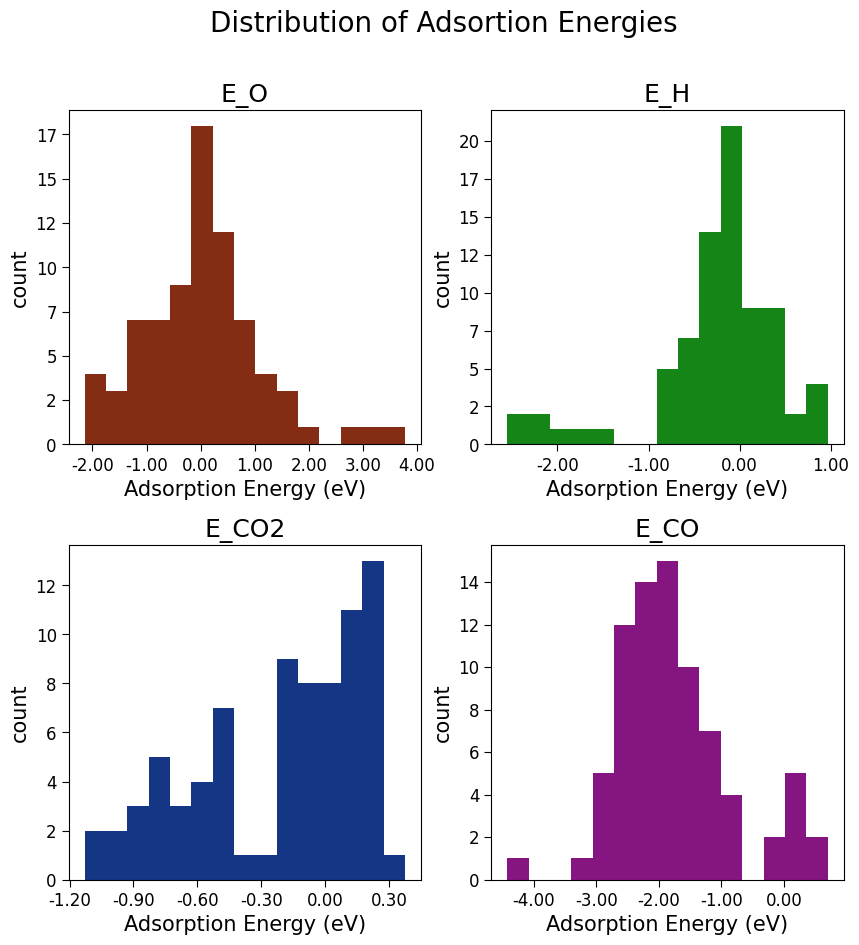

In [94]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as ticker


colors = ['#852C15', '#158517','#153585','#851581']
fig, axs = plt.subplots(2,2,figsize=(10,10))
fig.suptitle('Distribution of Adsortion Energies', fontsize=20)
for i, ax in enumerate(axs.flatten()):
    ax.hist(target[tasks[i]],color=colors[i],bins=15)
    ax.set_title(tasks[i],fontsize=18)
    ax.set_xlabel('Adsorption Energy (eV)',fontsize=15)
    ax.set_ylabel('count',fontsize=15)
    # ticks = np.linspace(int(eval(target[tasks[i]].min())-1),int(eval(target[tasks[i]].max())+1),5)
    # ax.set_xticks(ticks)
    ax.tick_params(axis='both',which = 'major',labelsize=12,length = 5,)
    if i == 2:
        ax.xaxis.set_major_locator(ticker.MultipleLocator(0.3))
    else:
        ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
        
    ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))
    ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%0.2f'))


fig.subplots_adjust(hspace=0.3,)

# Featurization

In [95]:
from mp_api.client import MPRester
API_KEY = "f87a4pCcUJ5wDNzvsdirVSByQscvc6ZF"
mpr = MPRester(API_KEY,use_document_model=False)

/Users/yujinkang/anaconda3/envs/laiddmg/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [96]:
#Add properties of each substrate and dopant for featurization
sub_df = mpr.materials.summary.search(formula = substrate_list, num_elements =(1),fields=['formula_pretty','material_id','energy_above_hull','is_metal','is_stable','structure','symmetry'])
sub_df = pd.DataFrame(sub_df)
sub_df = sub_df[sub_df['is_stable']]
if sub_df['energy_above_hull'].all() == 0:
    sub_df = sub_df.drop(['is_stable','energy_above_hull','structure','symmetry','is_metal'],axis=1)
else:
    print('Unstable Metal Present')

if len(sub_df) == len(substrate_list):
    print(f'\nfound all {len(sub_df)} substrates from material projects')
elif len(sub_df) < len(substrate_list):
    print("didn't get all substrates")
else:
    print('more substrates than expected')
sub_df.head(3)

Retrieving SummaryDoc documents: 100%|██████████| 34/34 [00:00<00:00, 396128.71it/s]


found all 6 substrates from material projects


,formula_pretty,material_id
3,Au,mp-81
7,Ni,mp-23
10,Ag,mp-8566


In [97]:
#Add properties of each substrate and dopant for featurization
dop_df = mpr.materials.summary.search(formula = dopant_list, num_elements =(1),fields=['formula_pretty','material_id','energy_above_hull','is_metal','is_stable','structure','symmetry'])
dop_df = pd.DataFrame(dop_df)
dop_df = dop_df[dop_df['is_stable']]
if dop_df['energy_above_hull'].all() == 0:
    dop_df = dop_df.drop(['is_stable','energy_above_hull','structure','symmetry','is_metal'],axis=1)
else:
    print('Unstable Metal Present')

if len(dop_df) == len(dopant_list):
    print(f'\nfound all {len(dop_df)} dopants from material projects')
elif len(dop_df) < len(dopant_list):
    print("didn't get all dopants")
else:
    print('more dopants than expected')
dop_df.head(3)

Retrieving SummaryDoc documents: 100%|██████████| 79/79 [00:00<00:00, 487279.44it/s]


found all 13 dopants from material projects


,formula_pretty,material_id
0,Ir,mp-101
8,Mn,mp-35
16,Mo,mp-129


In [98]:
#featurization

from matminer.featurizers.conversions import StrToComposition
from matminer.featurizers.composition import ElementProperty
from matminer.featurizers.composition.element import TMetalFraction, BandCenter
from matminer.featurizers.composition.orbital import ValenceOrbital
from matminer.featurizers.composition.ion import ElectronAffinity

In [99]:
# use featurizers from the paper
element_property_featurizer = ElementProperty.from_preset(preset_name="magpie")
tm_featurizer = TMetalFraction()
bc_featurizer = BandCenter()
vo_featurizer = ValenceOrbital()

In [102]:
cnvrt_sub_df = StrToComposition().featurize_dataframe(sub_df, 'formula_pretty')
cnvrt_sub_df = element_property_featurizer.featurize_dataframe(cnvrt_sub_df, col_id="composition", ignore_errors=True)
cnvrt_sub_df = tm_featurizer.featurize_dataframe(cnvrt_sub_df, col_id="composition", ignore_errors=True)
cnvrt_sub_df = bc_featurizer.featurize_dataframe(cnvrt_sub_df, col_id="composition", ignore_errors=True)
cnvrt_sub_df = vo_featurizer.featurize_dataframe(cnvrt_sub_df, col_id="composition", ignore_errors=True)
cnvrt_sub_df.head()

ValenceOrbital: 100%|██████████| 6/6 [00:00<00:00, 71.22it/s]


,formula_pretty,material_id,composition,MagpieData minimum Number,MagpieData maximum Number,MagpieData range Number,MagpieData mean Number,MagpieData avg_dev Number,MagpieData mode Number,MagpieData minimum MendeleevNumber,...,transition metal fraction,band center,avg s valence electrons,avg p valence electrons,avg d valence electrons,avg f valence electrons,frac s valence electrons,frac p valence electrons,frac d valence electrons,frac f valence electrons
3,Au,mp-81,(Au),79.0,79.0,0.0,79.0,0.0,79.0,66.0,...,0.0,5.767517,1.0,0.0,10.0,14.0,0.040000,0.0,0.400000,0.560000
7,Ni,mp-23,(Ni),28.0,28.0,0.0,28.0,0.0,28.0,61.0,...,1.0,4.400394,2.0,0.0,8.0,0.0,0.200000,0.0,0.800000,0.000000
10,Ag,mp-8566,(Ag),47.0,47.0,0.0,47.0,0.0,47.0,65.0,...,1.0,4.439262,1.0,0.0,10.0,0.0,0.090909,0.0,0.909091,0.000000
15,Cu,mp-30,(Cu),29.0,29.0,0.0,29.0,0.0,29.0,64.0,...,1.0,4.477094,1.0,0.0,10.0,0.0,0.090909,0.0,0.909091,0.000000
24,Pt,mp-126,(Pt),78.0,78.0,0.0,78.0,0.0,78.0,63.0,...,1.0,5.572658,1.0,0.0,9.0,14.0,0.041667,0.0,0.375000,0.583333


In [103]:
cnvrt_dop_df = StrToComposition().featurize_dataframe(dop_df, 'formula_pretty')
cnvrt_dop_df = element_property_featurizer.featurize_dataframe(cnvrt_dop_df, col_id="composition", ignore_errors=True)
cnvrt_dop_df = tm_featurizer.featurize_dataframe(cnvrt_dop_df, col_id="composition", ignore_errors=True)
cnvrt_dop_df = bc_featurizer.featurize_dataframe(cnvrt_dop_df, col_id="composition", ignore_errors=True)
cnvrt_dop_df = vo_featurizer.featurize_dataframe(cnvrt_dop_df, col_id="composition", ignore_errors=True)
cnvrt_dop_df.head()

ValenceOrbital: 100%|██████████| 13/13 [00:00<00:00, 281.11it/s]


,formula_pretty,material_id,composition,MagpieData minimum Number,MagpieData maximum Number,MagpieData range Number,MagpieData mean Number,MagpieData avg_dev Number,MagpieData mode Number,MagpieData minimum MendeleevNumber,...,transition metal fraction,band center,avg s valence electrons,avg p valence electrons,avg d valence electrons,avg f valence electrons,frac s valence electrons,frac p valence electrons,frac d valence electrons,frac f valence electrons
0,Ir,mp-101,(Ir),77.0,77.0,0.0,77.0,0.0,77.0,60.0,...,1.0,5.343076,2.0,0.0,7.0,14.0,0.086957,0.0,0.304348,0.608696
8,Mn,mp-35,(Mn),25.0,25.0,0.0,25.0,0.0,25.0,52.0,...,1.0,3.717351,2.0,0.0,5.0,0.0,0.285714,0.0,0.714286,0.000000
16,Mo,mp-129,(Mo),42.0,42.0,0.0,42.0,0.0,42.0,50.0,...,1.0,3.918947,1.0,0.0,5.0,0.0,0.166667,0.0,0.833333,0.000000
22,Os,mp-49,(Os),76.0,76.0,0.0,76.0,0.0,76.0,57.0,...,1.0,4.903089,2.0,0.0,6.0,14.0,0.090909,0.0,0.272727,0.636364
24,Re,mp-1186901,(Re),75.0,75.0,0.0,75.0,0.0,75.0,54.0,...,1.0,4.013785,2.0,0.0,5.0,14.0,0.095238,0.0,0.238095,0.666667


In [115]:
# paper use 'mean' values from Magie electron property data
sub_remove_cols = []
for col in cnvrt_sub_df.columns.to_list():
    if ('Magpie' in col) and ('mean' not in col):
        sub_remove_cols.append(col)
# print(sub_remove_cols)
cnvrt_sub_df = cnvrt_sub_df.drop(sub_remove_cols,axis=1)

In [128]:
# paper use 'mean' values from Magie electron property data
dop_remove_cols = []
for col in cnvrt_dop_df.columns.to_list():
    if ('Magpie' in col) and ('mean' not in col):
        dop_remove_cols.append(col)
        
cnvrt_dop_df = cnvrt_dop_df.drop(dop_remove_cols,axis=1)

In [131]:
# save featurized dopants 
cnvrt_sub_df.to_csv('./data/substrate_df.csv')
cnvrt_dop_df.to_csv('./data/dopant_df.csv')

# Preparing input

In [133]:
# make feature dataframe of corresponding substrates
sub_df_feat = pd.DataFrame(columns = ['sub_'+col for col in cnvrt_sub_df.columns])
cnvrt_sub_df = cnvrt_sub_df.set_axis(cnvrt_sub_df['formula_pretty'],axis=0)
for i, s in enumerate(Eads_df['Substrate']):
    sub_df_feat.loc[i] = cnvrt_sub_df.loc[s].to_list()
sub_df_feat

,sub_formula_pretty,sub_material_id,sub_composition,sub_MagpieData mean Number,sub_MagpieData mean MendeleevNumber,sub_MagpieData mean AtomicWeight,sub_MagpieData mean MeltingT,sub_MagpieData mean Column,sub_MagpieData mean Row,sub_MagpieData mean CovalentRadius,...,sub_transition metal fraction,sub_band center,sub_avg s valence electrons,sub_avg p valence electrons,sub_avg d valence electrons,sub_avg f valence electrons,sub_frac s valence electrons,sub_frac p valence electrons,sub_frac d valence electrons,sub_frac f valence electrons
0,Ag,mp-8566,(Ag),47.0,65.0,107.868200,1234.93,11.0,5.0,145.0,...,1.0,4.439262,1.0,0.0,10.0,0.0,0.090909,0.0,0.909091,0.0
1,Ag,mp-8566,(Ag),47.0,65.0,107.868200,1234.93,11.0,5.0,145.0,...,1.0,4.439262,1.0,0.0,10.0,0.0,0.090909,0.0,0.909091,0.0
2,Ag,mp-8566,(Ag),47.0,65.0,107.868200,1234.93,11.0,5.0,145.0,...,1.0,4.439262,1.0,0.0,10.0,0.0,0.090909,0.0,0.909091,0.0
3,Ag,mp-8566,(Ag),47.0,65.0,107.868200,1234.93,11.0,5.0,145.0,...,1.0,4.439262,1.0,0.0,10.0,0.0,0.090909,0.0,0.909091,0.0
4,Ag,mp-8566,(Ag),47.0,65.0,107.868200,1234.93,11.0,5.0,145.0,...,1.0,4.439262,1.0,0.0,10.0,0.0,0.090909,0.0,0.909091,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73,Co,mp-102,(Co),27.0,58.0,58.933195,1768.00,9.0,4.0,126.0,...,1.0,4.270833,2.0,0.0,7.0,0.0,0.222222,0.0,0.777778,0.0
74,Co,mp-102,(Co),27.0,58.0,58.933195,1768.00,9.0,4.0,126.0,...,1.0,4.270833,2.0,0.0,7.0,0.0,0.222222,0.0,0.777778,0.0
75,Co,mp-102,(Co),27.0,58.0,58.933195,1768.00,9.0,4.0,126.0,...,1.0,4.270833,2.0,0.0,7.0,0.0,0.222222,0.0,0.777778,0.0
76,Co,mp-102,(Co),27.0,58.0,58.933195,1768.00,9.0,4.0,126.0,...,1.0,4.270833,2.0,0.0,7.0,0.0,0.222222,0.0,0.777778,0.0


In [134]:
# make feature dataframe of corresponding dopants
dop_df_feat = pd.DataFrame(columns = ['dop_'+col for col in cnvrt_dop_df.columns])
cnvrt_dop_df = cnvrt_dop_df.set_axis(cnvrt_dop_df['formula_pretty'],axis=0)
for i, s in enumerate(Eads_df['Dopant']):
    dop_df_feat.loc[i] = cnvrt_dop_df.loc[s].to_list()
dop_df_feat

,dop_formula_pretty,dop_material_id,dop_composition,dop_MagpieData mean Number,dop_MagpieData mean MendeleevNumber,dop_MagpieData mean AtomicWeight,dop_MagpieData mean MeltingT,dop_MagpieData mean Column,dop_MagpieData mean Row,dop_MagpieData mean CovalentRadius,...,dop_transition metal fraction,dop_band center,dop_avg s valence electrons,dop_avg p valence electrons,dop_avg d valence electrons,dop_avg f valence electrons,dop_frac s valence electrons,dop_frac p valence electrons,dop_frac d valence electrons,dop_frac f valence electrons
0,Co,mp-102,(Co),27.0,58.0,58.933195,1768.0,9.0,4.0,126.0,...,1.0,4.270833,2.0,0.0,7.0,0.0,0.222222,0.0,0.777778,0.000000
1,Cr,mp-90,(Cr),24.0,49.0,51.996100,2180.0,6.0,4.0,139.0,...,1.0,3.716833,1.0,0.0,5.0,0.0,0.166667,0.0,0.833333,0.000000
2,Fe,mp-13,(Fe),26.0,55.0,55.845000,1811.0,8.0,4.0,132.0,...,1.0,4.032960,2.0,0.0,6.0,0.0,0.250000,0.0,0.750000,0.000000
3,Ir,mp-101,(Ir),77.0,60.0,192.217000,2739.0,9.0,6.0,141.0,...,1.0,5.343076,2.0,0.0,7.0,14.0,0.086957,0.0,0.304348,0.608696
4,Mn,mp-35,(Mn),25.0,52.0,54.938045,1519.0,7.0,4.0,139.0,...,1.0,3.717351,2.0,0.0,5.0,0.0,0.285714,0.0,0.714286,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73,Ru,mp-33,(Ru),44.0,56.0,101.070000,2607.0,8.0,5.0,146.0,...,1.0,4.205535,1.0,0.0,7.0,0.0,0.125000,0.0,0.875000,0.000000
74,Ta,mp-569794,(Ta),73.0,48.0,180.947880,3290.0,5.0,6.0,170.0,...,1.0,4.104478,2.0,0.0,3.0,14.0,0.105263,0.0,0.157895,0.736842
75,Tc,mp-113,(Tc),43.0,53.0,98.000000,2430.0,7.0,5.0,147.0,...,1.0,3.912728,2.0,0.0,5.0,0.0,0.285714,0.0,0.714286,0.000000
76,V,mp-146,(V),23.0,46.0,50.941500,2183.0,5.0,4.0,153.0,...,1.0,3.635468,2.0,0.0,3.0,0.0,0.400000,0.0,0.600000,0.000000


In [135]:
# concat dataframes and create input df
feat_concat = pd.concat([sub_df_feat, dop_df_feat],axis=1)
input_df = pd.concat([Eads_df, feat_concat],axis=1)

In [136]:
#save df
pd.set_option('display.max_rows', 30)
pd.set_option('display.max_columns', 400)
input_df.to_csv('./data/featurized_input_df.csv')
input_df

,name,E_O,E_H,E_CO2,E_CO,Substrate,Dopant,sub_formula_pretty,sub_material_id,sub_composition,sub_MagpieData mean Number,sub_MagpieData mean MendeleevNumber,sub_MagpieData mean AtomicWeight,sub_MagpieData mean MeltingT,sub_MagpieData mean Column,sub_MagpieData mean Row,sub_MagpieData mean CovalentRadius,sub_MagpieData mean Electronegativity,sub_MagpieData mean NsValence,sub_MagpieData mean NpValence,sub_MagpieData mean NdValence,sub_MagpieData mean NfValence,sub_MagpieData mean NValence,sub_MagpieData mean NsUnfilled,sub_MagpieData mean NpUnfilled,sub_MagpieData mean NdUnfilled,sub_MagpieData mean NfUnfilled,sub_MagpieData mean NUnfilled,sub_MagpieData mean GSvolume_pa,sub_MagpieData mean GSbandgap,sub_MagpieData mean GSmagmom,sub_MagpieData mean SpaceGroupNumber,sub_transition metal fraction,sub_band center,sub_avg s valence electrons,sub_avg p valence electrons,sub_avg d valence electrons,sub_avg f valence electrons,sub_frac s valence electrons,sub_frac p valence electrons,sub_frac d valence electrons,sub_frac f valence electrons,dop_formula_pretty,dop_material_id,dop_composition,dop_MagpieData mean Number,dop_MagpieData mean MendeleevNumber,dop_MagpieData mean AtomicWeight,dop_MagpieData mean MeltingT,dop_MagpieData mean Column,dop_MagpieData mean Row,dop_MagpieData mean CovalentRadius,dop_MagpieData mean Electronegativity,dop_MagpieData mean NsValence,dop_MagpieData mean NpValence,dop_MagpieData mean NdValence,dop_MagpieData mean NfValence,dop_MagpieData mean NValence,dop_MagpieData mean NsUnfilled,dop_MagpieData mean NpUnfilled,dop_MagpieData mean NdUnfilled,dop_MagpieData mean NfUnfilled,dop_MagpieData mean NUnfilled,dop_MagpieData mean GSvolume_pa,dop_MagpieData mean GSbandgap,dop_MagpieData mean GSmagmom,dop_MagpieData mean SpaceGroupNumber,dop_transition metal fraction,dop_band center,dop_avg s valence electrons,dop_avg p valence electrons,dop_avg d valence electrons,dop_avg f valence electrons,dop_frac s valence electrons,dop_frac p valence electrons,dop_frac d valence electrons,dop_frac f valence electrons
0,Ag_Co,0.420556,0.291260,-0.215400,-2.33778,Ag,Co,Ag,mp-8566,(Ag),47.0,65.0,107.868200,1234.93,11.0,5.0,145.0,1.93,1.0,0.0,10.0,0.0,11.0,1.0,0.0,0.0,0.0,1.0,16.330,0.0,0.000000,225.0,1.0,4.439262,1.0,0.0,10.0,0.0,0.090909,0.0,0.909091,0.0,Co,mp-102,(Co),27.0,58.0,58.933195,1768.0,9.0,4.0,126.0,1.88,2.0,0.0,7.0,0.0,9.0,0.0,0.0,3.0,0.0,3.0,10.245000,0.0,1.548471,194.0,1.0,4.270833,2.0,0.0,7.0,0.0,0.222222,0.0,0.777778,0.000000
1,Ag_Cr,-1.294170,-0.069320,-0.552660,-2.20352,Ag,Cr,Ag,mp-8566,(Ag),47.0,65.0,107.868200,1234.93,11.0,5.0,145.0,1.93,1.0,0.0,10.0,0.0,11.0,1.0,0.0,0.0,0.0,1.0,16.330,0.0,0.000000,225.0,1.0,4.439262,1.0,0.0,10.0,0.0,0.090909,0.0,0.909091,0.0,Cr,mp-90,(Cr),24.0,49.0,51.996100,2180.0,6.0,4.0,139.0,1.66,1.0,0.0,5.0,0.0,6.0,1.0,0.0,5.0,0.0,6.0,11.190000,0.0,0.000000,229.0,1.0,3.716833,1.0,0.0,5.0,0.0,0.166667,0.0,0.833333,0.000000
2,Ag_Fe,-0.097410,-0.326930,-0.466100,-2.58491,Ag,Fe,Ag,mp-8566,(Ag),47.0,65.0,107.868200,1234.93,11.0,5.0,145.0,1.93,1.0,0.0,10.0,0.0,11.0,1.0,0.0,0.0,0.0,1.0,16.330,0.0,0.000000,225.0,1.0,4.439262,1.0,0.0,10.0,0.0,0.090909,0.0,0.909091,0.0,Fe,mp-13,(Fe),26.0,55.0,55.845000,1811.0,8.0,4.0,132.0,1.83,2.0,0.0,6.0,0.0,8.0,0.0,0.0,4.0,0.0,4.0,10.730000,0.0,2.110663,229.0,1.0,4.032960,2.0,0.0,6.0,0.0,0.250000,0.0,0.750000,0.000000
3,Ag_Ir,1.097783,-0.704610,0.060300,-2.55684,Ag,Ir,Ag,mp-8566,(Ag),47.0,65.0,107.868200,1234.93,11.0,5.0,145.0,1.93,1.0,0.0,10.0,0.0,11.0,1.0,0.0,0.0,0.0,1.0,16.330,0.0,0.000000,225.0,1.0,4.439262,1.0,0.0,10.0,0.0,0.090909,0.0,0.909091,0.0,Ir,mp-101,(Ir),77.0,60.0,192.217000,2739.0,9.0,6.0,141.0,2.20,2.0,0.0,7.0,14.0,23.0,0.0,0.0,3.0,0.0,3.0,14.210000,0.0,0.000000,225.0,1.0,5.343076,2.0,0.0,7.0,14.0,0.086957,0.0,0.304348,0.608696
4,Ag_Mn,-0.693490,-0.273920,-0.639200,-2.59237,Ag,Mn,Ag,mp-8566,(Ag),47.0,65.0,107.868200,1234.93,11.0,5.0,145.0,1.93,1.0,0.0,10.0,0.0,11.0,1.0,0.0,0.0,0.0,1.0,16.330,0.0,0.000000,225.0,1.0,4.439262,1.0,0.0,10.0,0.0,0.0909

In [137]:
# drop non-feature values from input_df 
input_df_clean = input_df.drop(['E_O','E_H','E_CO','E_CO2','Substrate','Dopant','sub_formula_pretty','dop_formula_pretty','sub_composition','dop_composition','sub_material_id','dop_material_id'],axis=1)
input_df_clean.to_csv('./data/input_df_clean.csv')

In [138]:
input_df_clean

,name,sub_MagpieData mean Number,sub_MagpieData mean MendeleevNumber,sub_MagpieData mean AtomicWeight,sub_MagpieData mean MeltingT,sub_MagpieData mean Column,sub_MagpieData mean Row,sub_MagpieData mean CovalentRadius,sub_MagpieData mean Electronegativity,sub_MagpieData mean NsValence,sub_MagpieData mean NpValence,sub_MagpieData mean NdValence,sub_MagpieData mean NfValence,sub_MagpieData mean NValence,sub_MagpieData mean NsUnfilled,sub_MagpieData mean NpUnfilled,sub_MagpieData mean NdUnfilled,sub_MagpieData mean NfUnfilled,sub_MagpieData mean NUnfilled,sub_MagpieData mean GSvolume_pa,sub_MagpieData mean GSbandgap,sub_MagpieData mean GSmagmom,sub_MagpieData mean SpaceGroupNumber,sub_transition metal fraction,sub_band center,sub_avg s valence electrons,sub_avg p valence electrons,sub_avg d valence electrons,sub_avg f valence electrons,sub_frac s valence electrons,sub_frac p valence electrons,sub_frac d valence electrons,sub_frac f valence electrons,dop_MagpieData mean Number,dop_MagpieData mean MendeleevNumber,dop_MagpieData mean AtomicWeight,dop_MagpieData mean MeltingT,dop_MagpieData mean Column,dop_MagpieData mean Row,dop_MagpieData mean CovalentRadius,dop_MagpieData mean Electronegativity,dop_MagpieData mean NsValence,dop_MagpieData mean NpValence,dop_MagpieData mean NdValence,dop_MagpieData mean NfValence,dop_MagpieData mean NValence,dop_MagpieData mean NsUnfilled,dop_MagpieData mean NpUnfilled,dop_MagpieData mean NdUnfilled,dop_MagpieData mean NfUnfilled,dop_MagpieData mean NUnfilled,dop_MagpieData mean GSvolume_pa,dop_MagpieData mean GSbandgap,dop_MagpieData mean GSmagmom,dop_MagpieData mean SpaceGroupNumber,dop_transition metal fraction,dop_band center,dop_avg s valence electrons,dop_avg p valence electrons,dop_avg d valence electrons,dop_avg f valence electrons,dop_frac s valence electrons,dop_frac p valence electrons,dop_frac d valence electrons,dop_frac f valence electrons
0,Ag_Co,47.0,65.0,107.868200,1234.93,11.0,5.0,145.0,1.93,1.0,0.0,10.0,0.0,11.0,1.0,0.0,0.0,0.0,1.0,16.330,0.0,0.000000,225.0,1.0,4.439262,1.0,0.0,10.0,0.0,0.090909,0.0,0.909091,0.0,27.0,58.0,58.933195,1768.0,9.0,4.0,126.0,1.88,2.0,0.0,7.0,0.0,9.0,0.0,0.0,3.0,0.0,3.0,10.245000,0.0,1.548471,194.0,1.0,4.270833,2.0,0.0,7.0,0.0,0.222222,0.0,0.777778,0.000000
1,Ag_Cr,47.0,65.0,107.868200,1234.93,11.0,5.0,145.0,1.93,1.0,0.0,10.0,0.0,11.0,1.0,0.0,0.0,0.0,1.0,16.330,0.0,0.000000,225.0,1.0,4.439262,1.0,0.0,10.0,0.0,0.090909,0.0,0.909091,0.0,24.0,49.0,51.996100,2180.0,6.0,4.0,139.0,1.66,1.0,0.0,5.0,0.0,6.0,1.0,0.0,5.0,0.0,6.0,11.190000,0.0,0.000000,229.0,1.0,3.716833,1.0,0.0,5.0,0.0,0.166667,0.0,0.833333,0.000000
2,Ag_Fe,47.0,65.0,107.868200,1234.93,11.0,5.0,145.0,1.93,1.0,0.0,10.0,0.0,11.0,1.0,0.0,0.0,0.0,1.0,16.330,0.0,0.000000,225.0,1.0,4.439262,1.0,0.0,10.0,0.0,0.090909,0.0,0.909091,0.0,26.0,55.0,55.845000,1811.0,8.0,4.0,132.0,1.83,2.0,0.0,6.0,0.0,8.0,0.0,0.0,4.0,0.0,4.0,10.730000,0.0,2.110663,229.0,1.0,4.032960,2.0,0.0,6.0,0.0,0.250000,0.0,0.750000,0.000000
3,Ag_Ir,47.0,65.0,107.868200,1234.93,11.0,5.0,145.0,1.93,1.0,0.0,10.0,0.0,11.0,1.0,0.0,0.0,0.0,1.0,16.330,0.0,0.000000,225.0,1.0,4.439262,1.0,0.0,10.0,0.0,0.090909,0.0,0.909091,0.0,77.0,60.0,192.217000,2739.0,9.0,6.0,141.0,2.20,2.0,0.0,7.0,14.0,23.0,0.0,0.0,3.0,0.0,3.0,14.210000,0.0,0.000000,225.0,1.0,5.343076,2.0,0.0,7.0,14.0,0.086957,0.0,0.304348,0.608696
4,Ag_Mn,47.0,65.0,107.868200,1234.93,11.0,5.0,145.0,1.93,1.0,0.0,10.0,0.0,11.0,1.0,0.0,0.0,0.0,1.0,16.330,0.0,0.000000,225.0,1.0,4.439262,1.0,0.0,10.0,0.0,0.090909,0.0,0.909091,0.0,25.0,52.0,54.938045,1519.0,7.0,4.0,139.0,1.55,2.0,0.0,5.0,0.0,7.0,0.0,0.0,5.0,0.0,5.0,10.487586,0.0,0.000310,217.0,1.0,3.717351,2.0,0.0,5.0,0.0,0.285714,0.0,0.714286,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73,Co_Ru,27.0,58.0,58.933195,1768.00,9

In [139]:
pd.set_option('display.max_rows', 30)
pd.set_option('display.max_columns', 9)
input_df_clean = input_df_clean.drop(['name'],axis=1)

In [140]:
input_df_clean

,sub_MagpieData mean Number,sub_MagpieData mean MendeleevNumber,sub_MagpieData mean AtomicWeight,sub_MagpieData mean MeltingT,...,dop_frac s valence electrons,dop_frac p valence electrons,dop_frac d valence electrons,dop_frac f valence electrons
0,47.0,65.0,107.868200,1234.93,...,0.222222,0.0,0.777778,0.000000
1,47.0,65.0,107.868200,1234.93,...,0.166667,0.0,0.833333,0.000000
2,47.0,65.0,107.868200,1234.93,...,0.250000,0.0,0.750000,0.000000
3,47.0,65.0,107.868200,1234.93,...,0.086957,0.0,0.304348,0.608696
4,47.0,65.0,107.868200,1234.93,...,0.285714,0.0,0.714286,0.000000
...,...,...,...,...,...,...,...,...,...
73,27.0,58.0,58.933195,1768.00,...,0.125000,0.0,0.875000,0.000000
74,27.0,58.0,58.933195,1768.00,...,0.105263,0.0,0.157895,0.736842
75,27.0,58.0,58.933195,1768.00,...,0.285714,0.0,0.714286,0.000000
76,27.0,58.0,58.933195,1768.00,...,0.400000,0.0,0.600000,0.000000


In [141]:
# draw Pearson correlation plot
pd.set_option('display.max_rows', 30)
pd.set_option('display.max_columns', 400)

#remove NaN
nan_cols = []
for c in input_df_clean.corr().columns:
    if len(input_df_clean.corr()[c].dropna()) == 0:
        nan_cols.append(c)


In [142]:
len(nan_cols)
input_df_clean2 = input_df_clean.drop(nan_cols, axis=1)

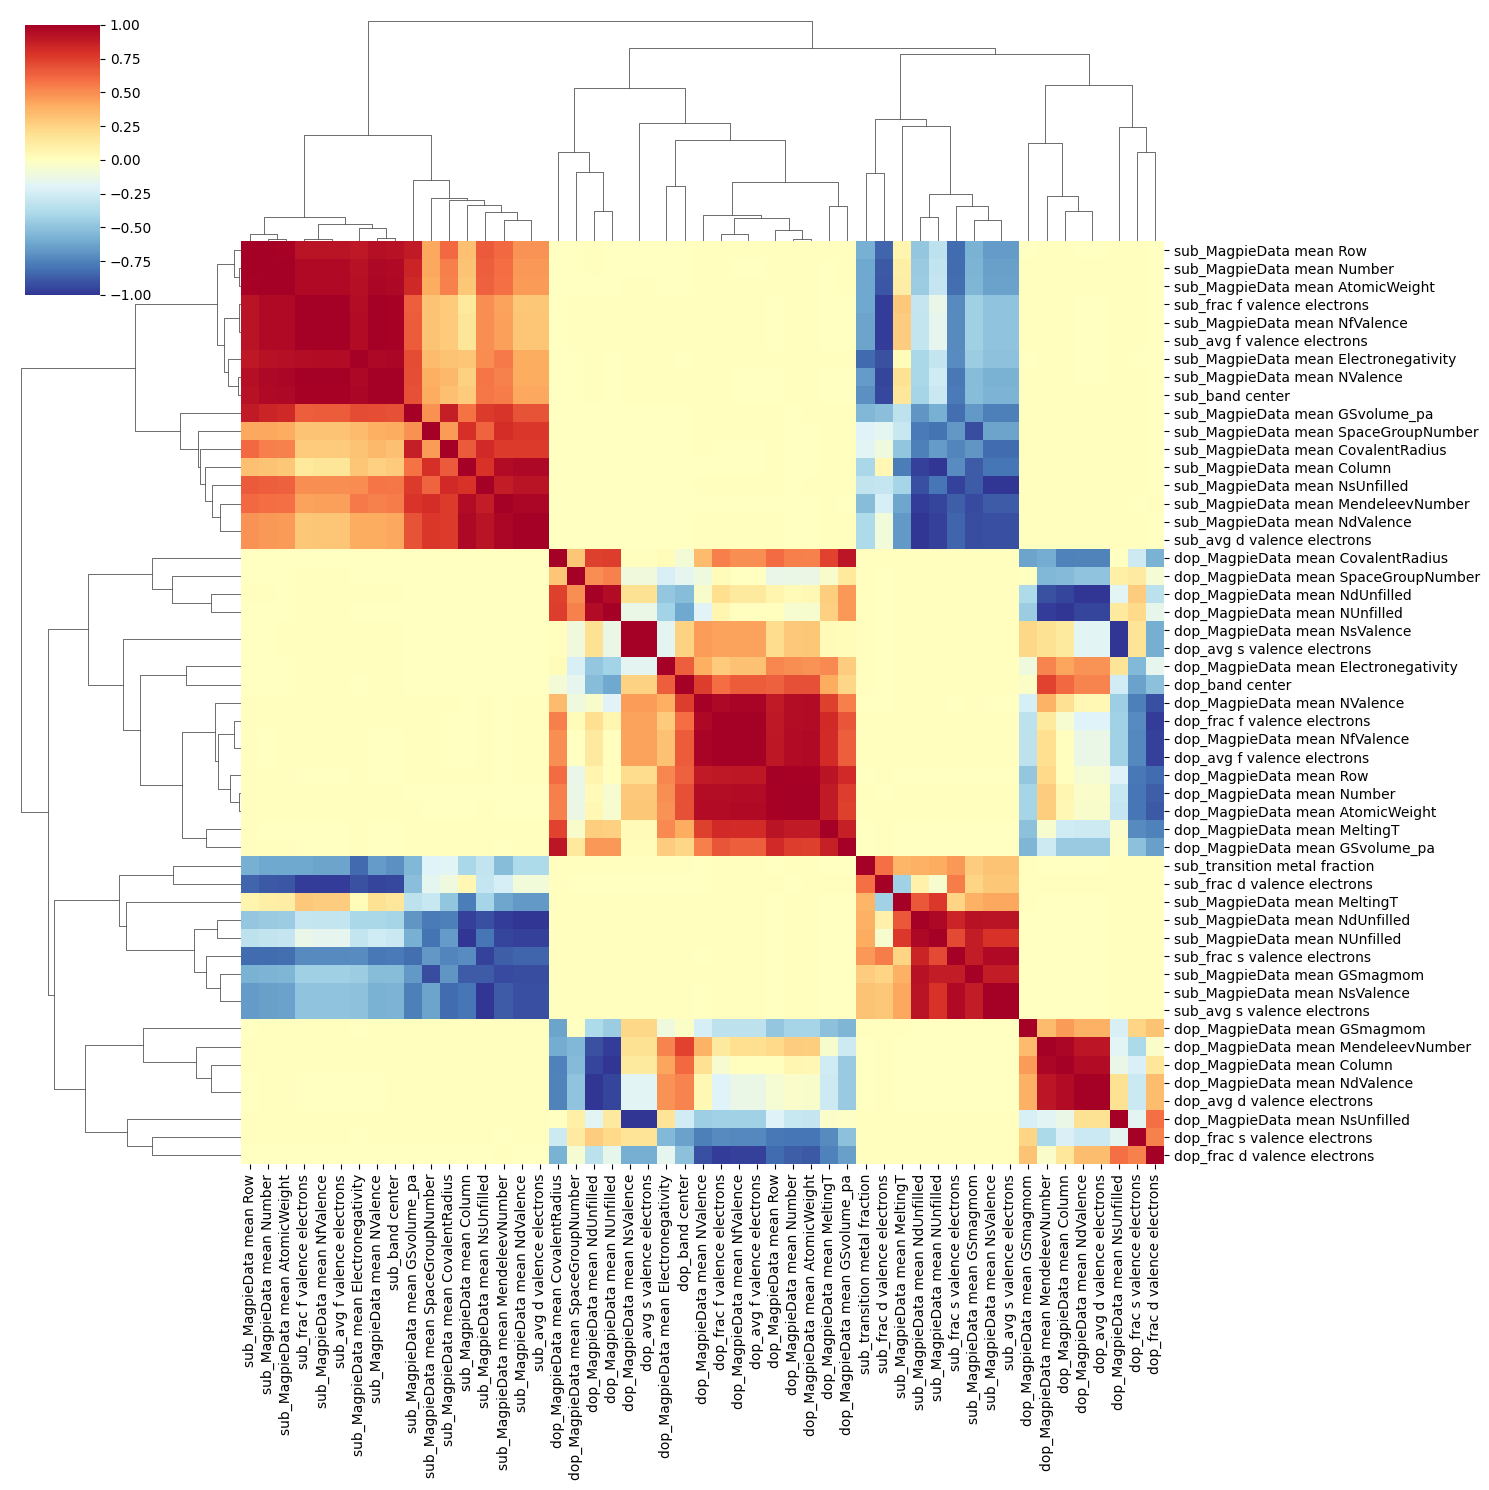

In [143]:
import seaborn as sns
sns.clustermap(input_df_clean2 .corr(),
               annot = False,      
               cmap = 'RdYlBu_r',  
               vmin = -1, vmax = 1,
               figsize=(15,15),
              );

In [144]:
input_df_clean2.to_csv('./data/input_df_clean2.csv')

# Modeling

In [200]:
import copy
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

random_seed = 42
X = copy.deepcopy(input_df_clean2)

modelpath = './models'
if not os.path.exists(modelpath):
    os.makedirs(modelpath)


### define plotting function

In [155]:
from mpl_toolkits.axes_grid1 import ImageGrid
def plotparities(Y):
    fig = plt.figure(figsize=(12,40))

    grid = ImageGrid(fig, 111, nrows_ncols = (4,2), axes_pad=(1,1), ngrids=8,label_mode = "all")


    R2 = [r2_score(Y[0][0]['E_O'].to_list(), Y[0][1].T[0]), r2_score(Y[1][0]['E_O'].to_list(), Y[1][1].T[0]),r2_score(Y[0][0]['E_H'].to_list(), Y[0][1].T[1]),r2_score(Y[1][0]['E_H'].to_list(), Y[1][1].T[1]),r2_score(Y[0][0]['E_CO2'].to_list(), Y[0][1].T[2]), r2_score(Y[1][0]['E_CO2'].to_list(), Y[1][1].T[2]), r2_score(Y[0][0]['E_CO'].to_list(), Y[0][1].T[3]), r2_score(Y[1][0]['E_CO'].to_list(), Y[1][1].T[3])]
    CO2 = r'$CO \rm_{2}$ '

    titles = ['Adsorption Energy of O - train set','Adsorption Energy of O - validation set', 'Adsorption Energy of H - train set','Adsorption Energy of H - validation set',r'Adsorption Energy of $\mathrm{CO_2}$ - train set',r'Adsorption Energy of $\mathrm{CO_2}$ - validation set','Adsorption Energy of CO - train set','Adsorption Energy of CO - validation set']

    for i, ax in enumerate(grid):

            ax.set_title(R2[i])
            ax.set_xlabel("Reference Value (eV)",fontsize=14,labelpad=2)
            ax.set_ylabel("Predicted Value (eV)",fontsize=14,labelpad=1)
            # ax.cax.tick_params(axis='y',length=15,width=4,labelsize=60)
            ax.set_xlim(-3,3)
            ax.set_ylim(-3,3)
            ax.axline(xy1=(0, 0), slope=1, color="gray", linewidth=1, linestyle="dashed")
            # legend = r'$\mathrm{R^2}$'+f' = {R2[i]:.2f}'
            ax.set_box_aspect(1)
            ax.text(1.5,2.7,r'$\mathrm{R^2}$'+f': {R2[i]:.3f}',fontsize=12)
            ax.set_title(titles[i], fontsize=15,pad=3)
            ax.tick_params(axis='both',which='major',length=4,labelsize=12,width=1)
            
            

    colors =['#4A59BE', '#E9892A', '#D1534E', '#439959']


    sc0 = grid[0].scatter(x=Y[0][0]['E_O'].to_list(), y=Y[0][1].T[0], marker='o', color=colors[0] ,s=50,alpha=0.9, edgecolors='k');
    sc2 = grid[2].scatter(x=Y[0][0]['E_H'].to_list(), y=Y[0][1].T[1], marker='o', color=colors[1] , s=50,alpha=0.9, edgecolors='k');
    sc4 = grid[4].scatter(x=Y[0][0]['E_CO2'].to_list(), y=Y[0][1].T[2], marker='o', color=colors[2] , s=50,alpha=0.9, edgecolors='k');
    sc6 = grid[6].scatter(x=Y[0][0]['E_CO'].to_list(), y=Y[0][1].T[3], marker='o', color=colors[3] , s=50,alpha=0.9, edgecolors='k');

    sc1 = grid[1].scatter(x=Y[1][0]['E_O'].to_list(), y=Y[1][1].T[0], marker='o', color=colors[0] , s=50,alpha=0.9, edgecolors='k');
    sc3 = grid[3].scatter(x=Y[1][0]['E_H'].to_list(), y=Y[1][1].T[1], marker='o', color=colors[1] , s=50,alpha=0.9, edgecolors='k');
    sc5 = grid[5].scatter(x=Y[1][0]['E_CO2'].to_list(), y=Y[1][1].T[2], color=colors[2] , marker='o', s=50,alpha=0.9, edgecolors='k');
    sc7 = grid[7].scatter(x=Y[1][0]['E_CO'].to_list(), y=Y[1][1].T[3], color=colors[3] , marker='o', s=50,alpha=0.9, edgecolors='k');


## Training with every Raw and Scaled Feature

### Model selection by performance with raw data

In [160]:
# Train with Raw Features

In [201]:
# Define function for model selection 
import pickle
import joblib

def check_model(model, model_name,return_model = False):
    X_train, X_test, y_train, y_test = train_test_split(X, target, test_size=1/6, random_state=random_seed)
    model.fit(X_train, y_train)
    y_pred_train = model.predict(X_train) 
    y_pred_test = model.predict(X_test) 
    Y = [[y_train, y_pred_train], [y_test,y_pred_test]]
    plotparities(Y)
    
    data = {'X': X, 'Y':Y,'params':model.get_params()}
    
    path = f'./models/{model_name}'
    if not os.path.exists(path):
        os.makedirs(path)
    
    with open(os.path.join(path, f'{model_name}_pickle.pkl'), 'wb') as file:
        pickle.dump(model, file)
    
    joblib.dump(model, os.path.join(path,f'{model_name}_joblib.pkl'))
    
    with open(os.path.join(path,'data.pkl'),'wb') as file:
        pickle.dump(data, file)
    
    if return_model:
        return model
    else:
        return

/Users/yujinkang/anaconda3/envs/laiddmg/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


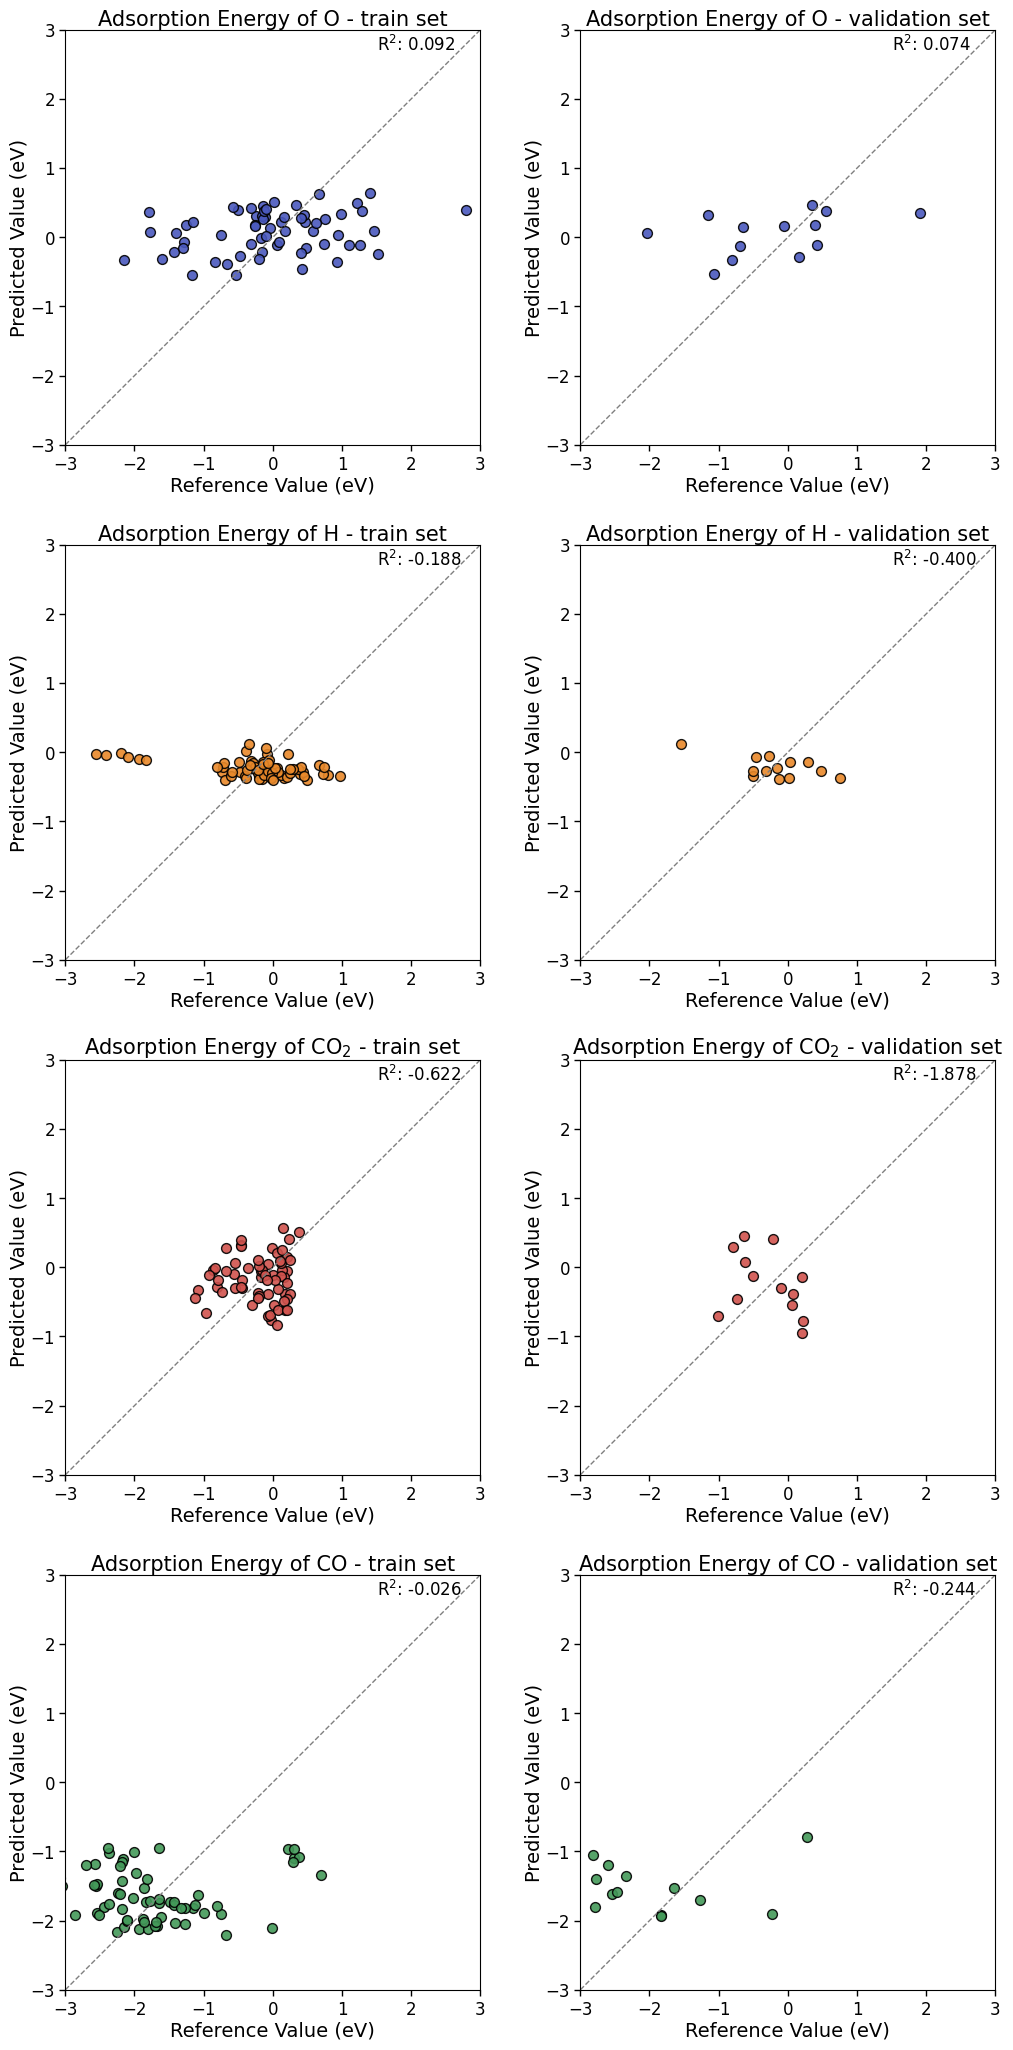

In [202]:
from sklearn.neural_network import MLPRegressor
# try mlp regression
model_nn = MLPRegressor(hidden_layer_sizes = (30,20,5,20, 30), activation='relu', solver='adam',random_state=0)

check_model(model = model_nn,model_name = 'mlp')

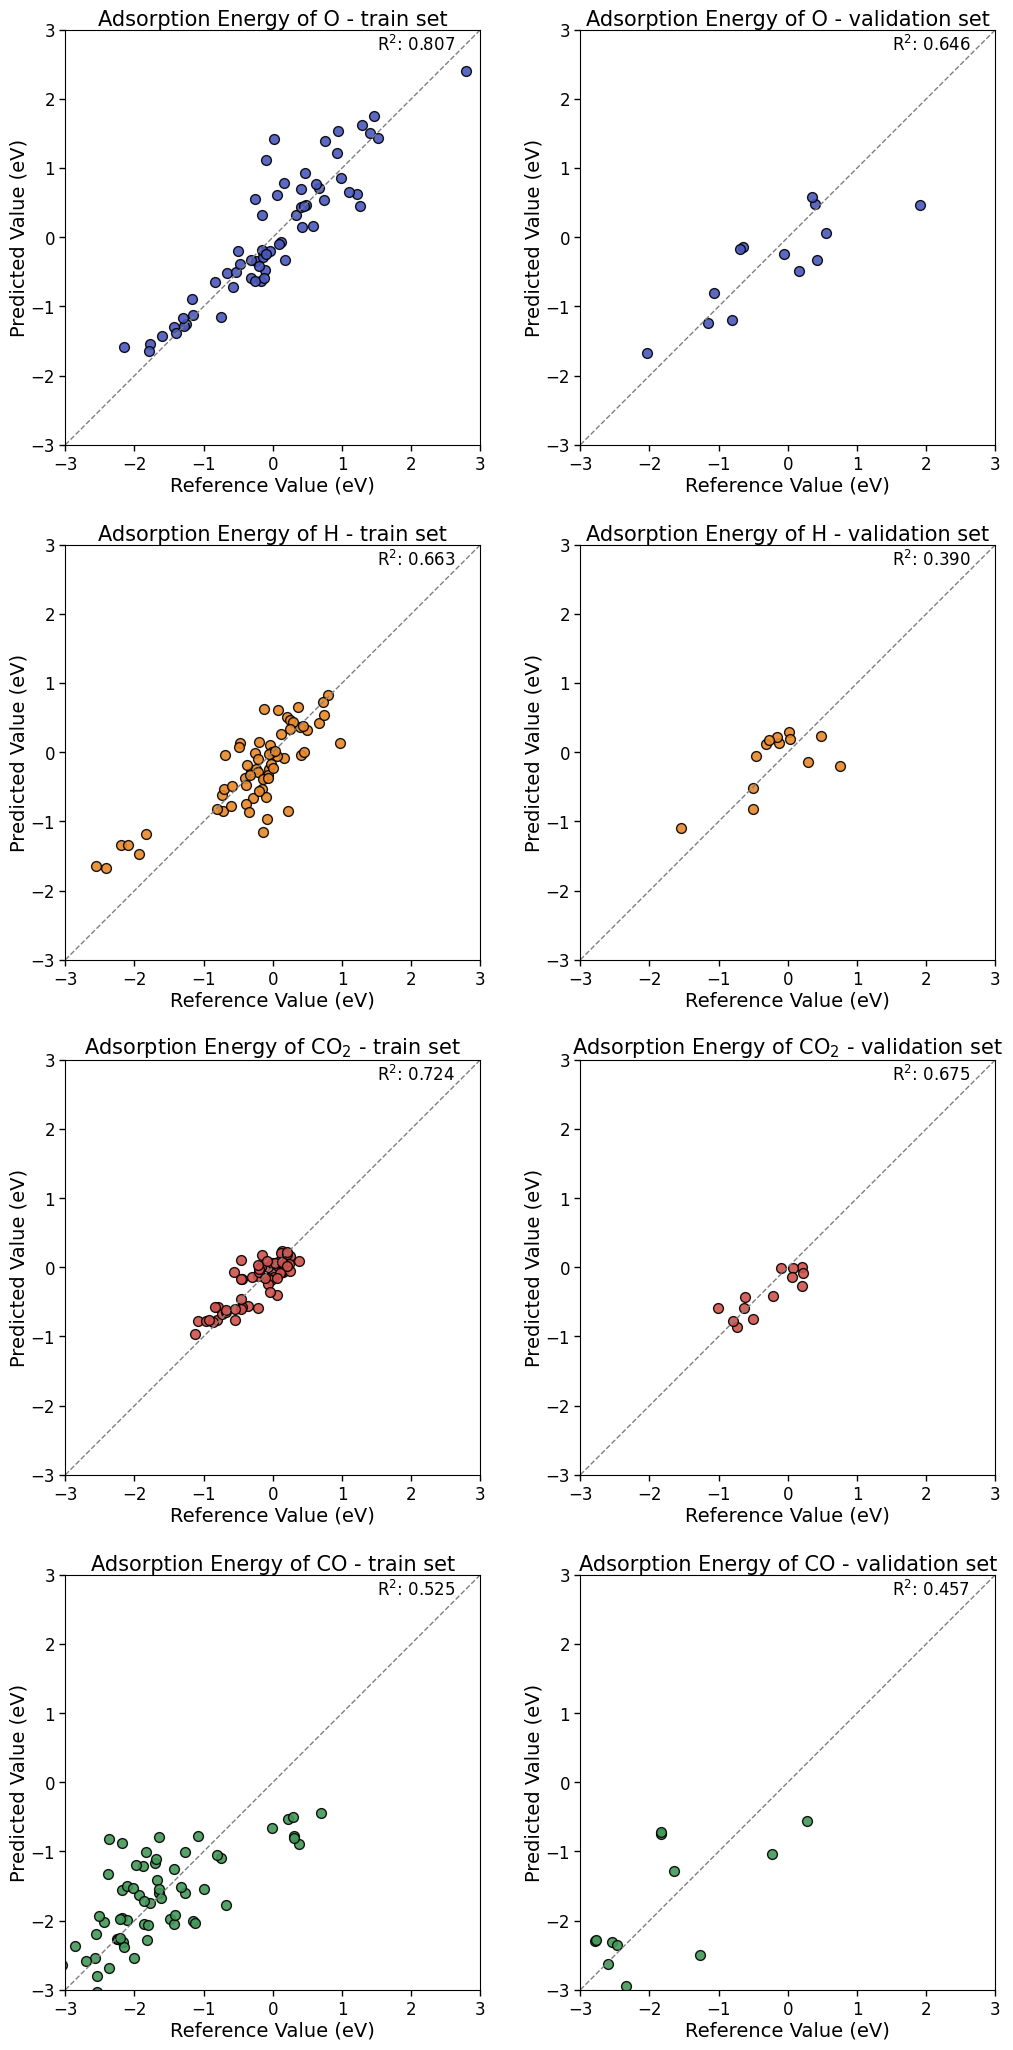

In [205]:
from sklearn.linear_model import LinearRegression
# try linear regression
model_lr = LinearRegression()
check_model(model = model_lr,model_name = 'lr')

## XGBRegressor

In [206]:
from xgboost import XGBRegressor
# try XGBRegressor

def scorer(y_test, y_pred):
    r2_O = r2_score(y_test['E_O'], y_pred.T[0])
    r2_H = r2_score(y_test['E_H'], y_pred.T[1])
    r2_CO2 = r2_score(y_test['E_CO2'], y_pred.T[2])
    r2_CO = r2_score(y_test['E_CO'], y_pred.T[3])
    
    r2 =  (r2_O  +  r2_H + r2_CO2 + r2_CO)/4
    return r2


def objective(trial):
    n_estimators = trial.suggest_int("n_estimators", 100, 800, step=50) 
    max_depth = trial.suggest_int("max_depth", 1, 10)
    learning_rate = trial.suggest_float("learning_rate", 1e-2, 1e-1, log=True)  
    reg_lambda = trial.suggest_float("reg_lambda", 0.3, 0.6) 
    reg_alpha = trial.suggest_float("reg_alpha", 0.3, 0.6)  

    model = XGBRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        reg_lambda=reg_lambda,
        reg_alpha=reg_alpha,
        early_stopping_rounds=200,
    )
    X_train, X_test, y_train, y_test = train_test_split(X, target, test_size=1/6, random_state=random_seed)
    model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)

    y_pred = model.predict(X_test)

    accuracy = scorer(y_test,y_pred)
    trial.set_user_attr("accuracy", accuracy)

    return accuracy

class StopWhenAccuracyOverCrit:  
    def __init__(self, crit): 
        self.crit = crit 

    def __call__(self, study, trial) -> None:        
        if trial.user_attrs["accuracy"] > self.crit:  
            study.stop() 
            
# Define function for model selection 

def xgbr_trainer(study, model_name, X = None, return_model = False):
    if X is None:
        X = X
    X_train, X_test, y_train, y_test = train_test_split(X, target, test_size=1/6, random_state=random_seed)
    model = XGBRegressor(**study.best_params)
    model.fit(X_train, y_train, eval_set=[(X_test, y_test)])
    y_pred_train = model.predict(X_train) 
    y_pred_test = model.predict(X_test) 
    Y = [[y_train, y_pred_train], [y_test,y_pred_test]]
    
    r2_O = r2_score(y_test['E_O'], y_pred_test.T[0])
    r2_H = r2_score(y_test['E_H'], y_pred_test.T[1])
    r2_CO2 = r2_score(y_test['E_CO2'], y_pred_test.T[2])
    r2_CO = r2_score(y_test['E_CO'], y_pred_test.T[3])

    print(f"r2_score of E_O at test set: {round(r2_O, 3)}")
    print(f"r2_score of E_H at test set: {round(r2_H, 3)}")
    print(f"r2_score of E_CO2 at test set: {round(r2_CO2, 3)}")
    print(f"r2_score of E_CO at test set: {round(r2_CO, 3)}")

    
    data = {'X': X, 'Y':Y,'params':model.get_params(),'study':study, 'study_best_params':study.best_params}
    
    path = f'./models/{model_name}'
    if not os.path.exists(path):
        os.makedirs(path)
    
    with open(os.path.join(path, f'{model_name}_pickle.pkl'), 'wb') as file:
        pickle.dump(model, file)
    
    joblib.dump(model, os.path.join(path,f'{model_name}_joblib.pkl'))
    
    with open(os.path.join(path,'data.pkl'),'wb') as file:
        pickle.dump(data, file)
        
    plotparities(Y)
    
    if return_model:
        return model
    else:
        return

In [189]:
# Optuna 이용하여 하이퍼파라미터 튜닝
import optuna

stop_search = StopWhenAccuracyOverCrit(0.95)
study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler(seed=3))
study.optimize(objective, callbacks=[stop_search])



[I 2024-06-12 17:09:06,247] A new study created in memory with name: no-name-249a732a-216d-4e1d-abe6-0dd59a43e156
[I 2024-06-12 17:09:07,817] Trial 0 finished with value: 0.44065478705847255 and parameters: {'n_estimators': 500, 'max_depth': 8, 'learning_rate': 0.019539108247609217, 'reg_lambda': 0.45324828155929886, 'reg_alpha': 0.5678840863042964}. Best is trial 0 with value: 0.44065478705847255.
[I 2024-06-12 17:09:08,368] Trial 1 finished with value: 0.37650876402898875 and parameters: {'n_estimators': 750, 'max_depth': 2, 'learning_rate': 0.01611546636770628, 'reg_lambda': 0.31544016099024896, 'reg_alpha': 0.4322429530951909}. Best is trial 0 with value: 0.44065478705847255.
[I 2024-06-12 17:09:08,512] Trial 2 finished with value: 0.40120776725646634 and parameters: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.0445804089021127, 'reg_lambda': 0.38354618479439256, 'reg_alpha': 0.5028764705940394}. Best is trial 0 with value: 0.44065478705847255.
[I 2024-06-12 17:09:08,78

KeyboardInterrupt: 

Best parameters: {'n_estimators': 200, 'max_depth': 9, 'learning_rate': 0.0640753723382648, 'reg_lambda': 0.45538453851650573, 'reg_alpha': 0.5128440408242144}
[0]	validation_0-rmse:1.09504
[1]	validation_0-rmse:1.05254
[2]	validation_0-rmse:1.01329
[3]	validation_0-rmse:0.97769
[4]	validation_0-rmse:0.94679
[5]	validation_0-rmse:0.91981
[6]	validation_0-rmse:0.89409
[7]	validation_0-rmse:0.86949
[8]	validation_0-rmse:0.85075
[9]	validation_0-rmse:0.83186
[10]	validation_0-rmse:0.81612
[11]	validation_0-rmse:0.79951
[12]	validation_0-rmse:0.78569
[13]	validation_0-rmse:0.77255
[14]	validation_0-rmse:0.76042
[15]	validation_0-rmse:0.74770
[16]	validation_0-rmse:0.73775
[17]	validation_0-rmse:0.72788
[18]	validation_0-rmse:0.71996
[19]	validation_0-rmse:0.71209
[20]	validation_0-rmse:0.70830
[21]	validation_0-rmse:0.70427
[22]	validation_0-rmse:0.70206
[23]	validation_0-rmse:0.69988
[24]	validation_0-rmse:0.69466
[25]	validation_0-rmse:0.69305
[26]	validation_0-rmse:0.69222
[27]	validati

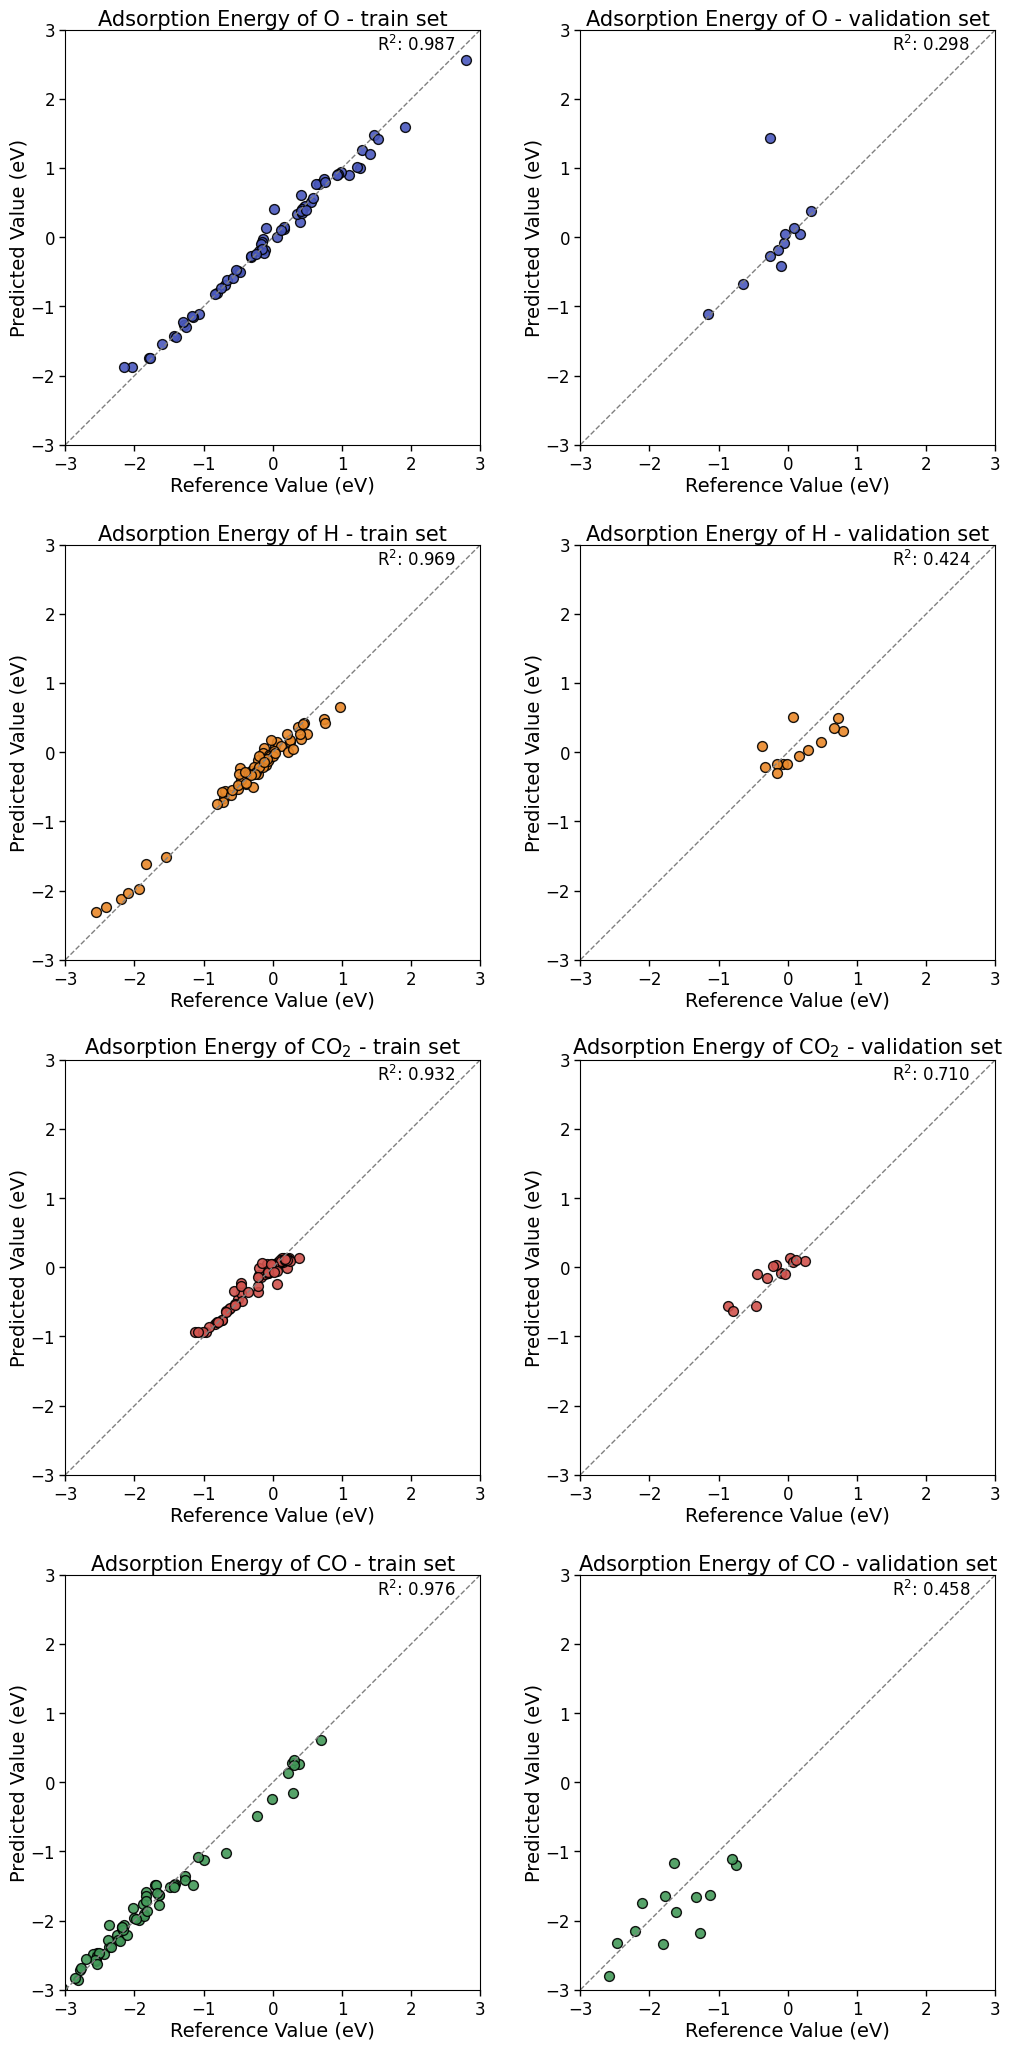

In [195]:
study.best_params
print("Best parameters:", study.best_params)

xgbr_trainer(study=study, model_name='xgbr_')

In [208]:
# scale properties
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X)
X_scl = scaler.transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scl, target, test_size=1/6, random_state=1)

def objective(trial):
    n_estimators = trial.suggest_int("n_estimators", 100, 800, step=50) 
    max_depth = trial.suggest_int("max_depth", 1, 10)
    learning_rate = trial.suggest_float("learning_rate", 1e-2, 1e-1, log=True)  
    reg_lambda = trial.suggest_float("reg_lambda", 0.3, 0.6) 
    reg_alpha = trial.suggest_float("reg_alpha", 0.3, 0.6)  

    model = XGBRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        reg_lambda=reg_lambda,
        reg_alpha=reg_alpha,
        early_stopping_rounds=200,
    )
    X_train, X_test, y_train, y_test = train_test_split(X_scl, target, test_size=1/6, random_state=random_seed)
    model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)

    y_pred = model.predict(X_test)

    accuracy = scorer(y_test,y_pred)
    trial.set_user_attr("accuracy", accuracy)

    return accuracy


In [209]:
stop_search = StopWhenAccuracyOverCrit(0.95)
study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler(seed=3))
study.optimize(objective, callbacks=[stop_search])


[I 2024-06-12 17:36:21,282] A new study created in memory with name: no-name-474c8893-3b65-407d-8d64-96e8cfdc9654
[I 2024-06-12 17:36:21,761] Trial 0 finished with value: 0.6549003655226353 and parameters: {'n_estimators': 500, 'max_depth': 8, 'learning_rate': 0.019539108247609217, 'reg_lambda': 0.45324828155929886, 'reg_alpha': 0.5678840863042964}. Best is trial 0 with value: 0.6549003655226353.
[I 2024-06-12 17:36:21,954] Trial 1 finished with value: 0.7164986676841781 and parameters: {'n_estimators': 750, 'max_depth': 2, 'learning_rate': 0.01611546636770628, 'reg_lambda': 0.31544016099024896, 'reg_alpha': 0.4322429530951909}. Best is trial 1 with value: 0.7164986676841781.
[I 2024-06-12 17:36:22,069] Trial 2 finished with value: 0.6597224106669747 and parameters: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.0445804089021127, 'reg_lambda': 0.38354618479439256, 'reg_alpha': 0.5028764705940394}. Best is trial 1 with value: 0.7164986676841781.
[I 2024-06-12 17:36:22,177] Tri

KeyboardInterrupt: 

Best parameters: {'n_estimators': 300, 'max_depth': 2, 'learning_rate': 0.012463804780791687, 'reg_lambda': 0.3067819204293054, 'reg_alpha': 0.3070586112115416}
[0]	validation_0-rmse:1.05300
[1]	validation_0-rmse:1.04424
[2]	validation_0-rmse:1.03564
[3]	validation_0-rmse:1.02691
[4]	validation_0-rmse:1.01860
[5]	validation_0-rmse:1.01015
[6]	validation_0-rmse:1.00206
[7]	validation_0-rmse:0.99407
[8]	validation_0-rmse:0.98627
[9]	validation_0-rmse:0.97855
[10]	validation_0-rmse:0.97103
[11]	validation_0-rmse:0.96357
[12]	validation_0-rmse:0.95631
[13]	validation_0-rmse:0.94870
[14]	validation_0-rmse:0.94168
[15]	validation_0-rmse:0.93428
[16]	validation_0-rmse:0.92736
[17]	validation_0-rmse:0.92075
[18]	validation_0-rmse:0.91364
[19]	validation_0-rmse:0.90687
[20]	validation_0-rmse:0.90017
[21]	validation_0-rmse:0.89392
[22]	validation_0-rmse:0.88773
[23]	validation_0-rmse:0.88141
[24]	validation_0-rmse:0.87494
[25]	validation_0-rmse:0.86850
[26]	validation_0-rmse:0.86234
[27]	validat

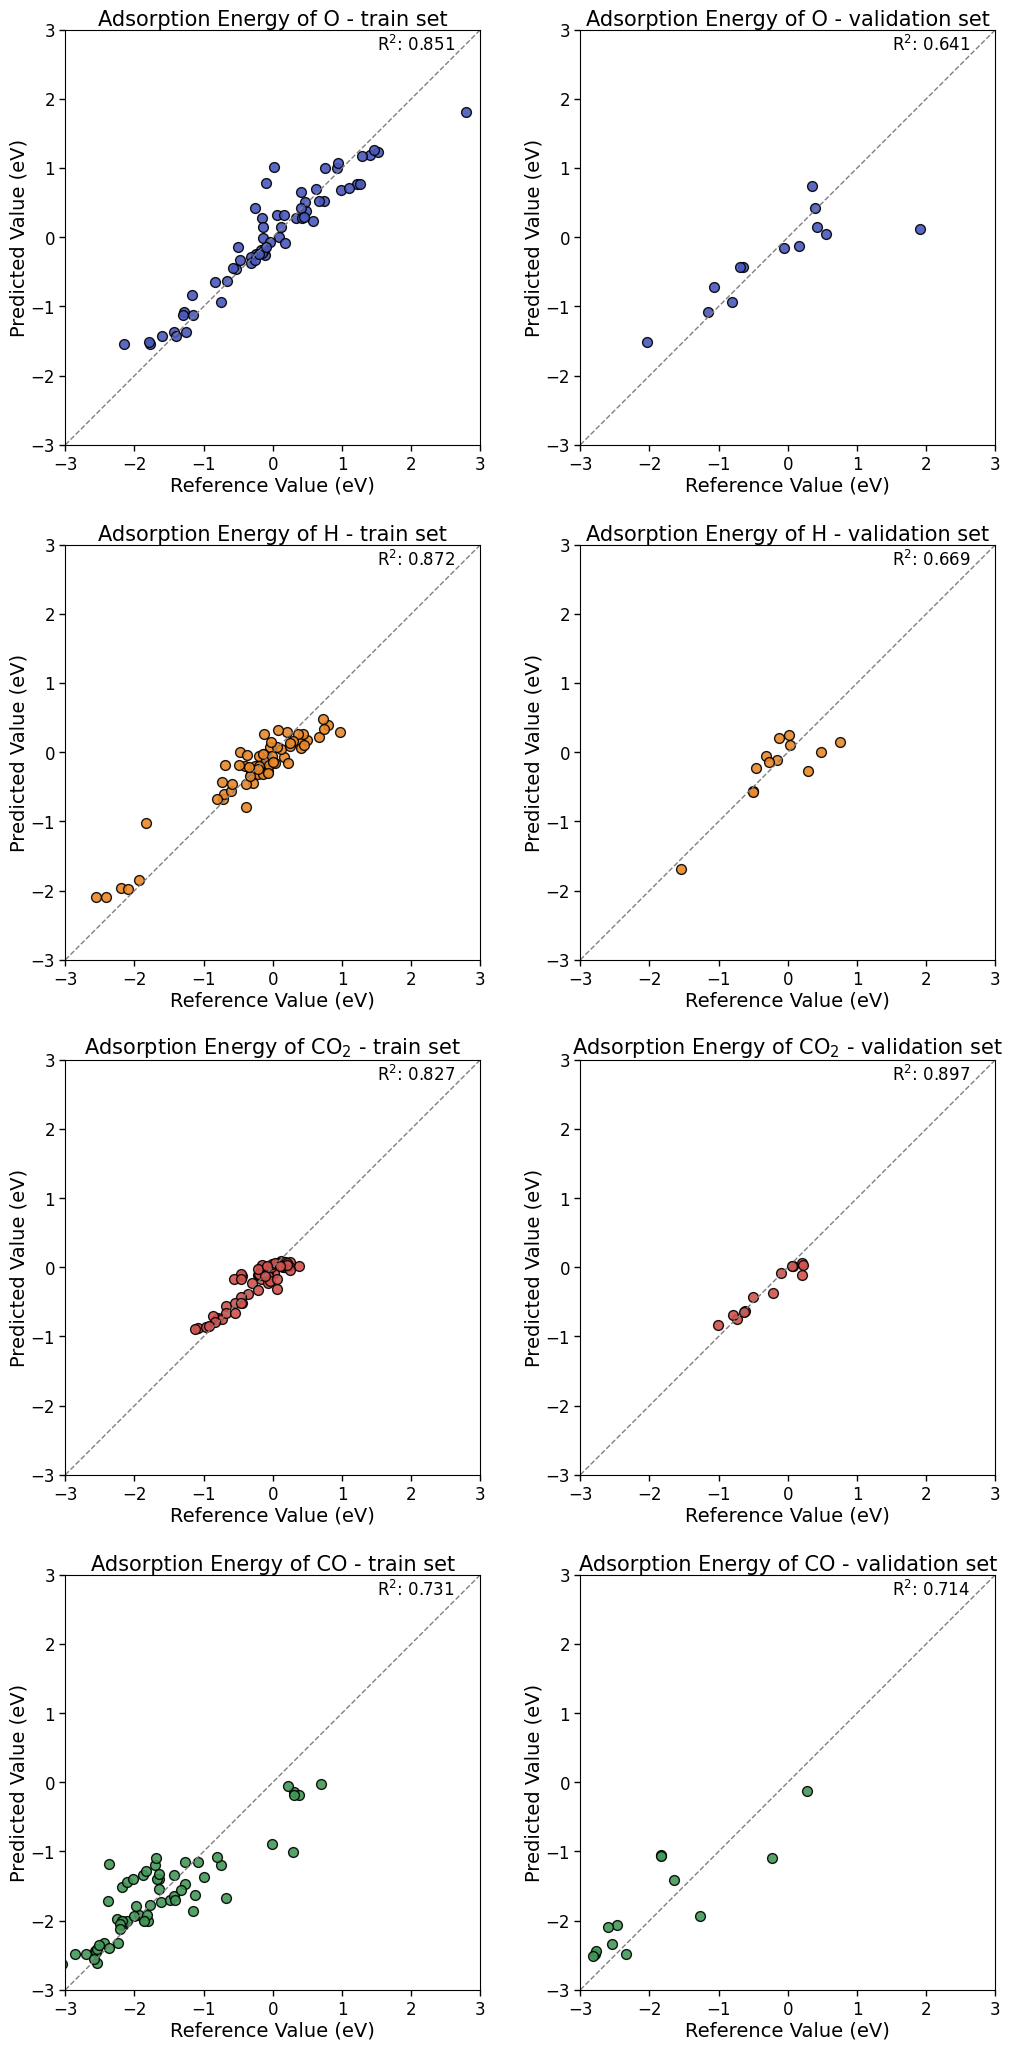

In [210]:
study.best_params
print("Best parameters:", study.best_params)

xgbr_trainer(study=study, model_name='xgbr_scaled')

## XGBRegressor - feature reduction

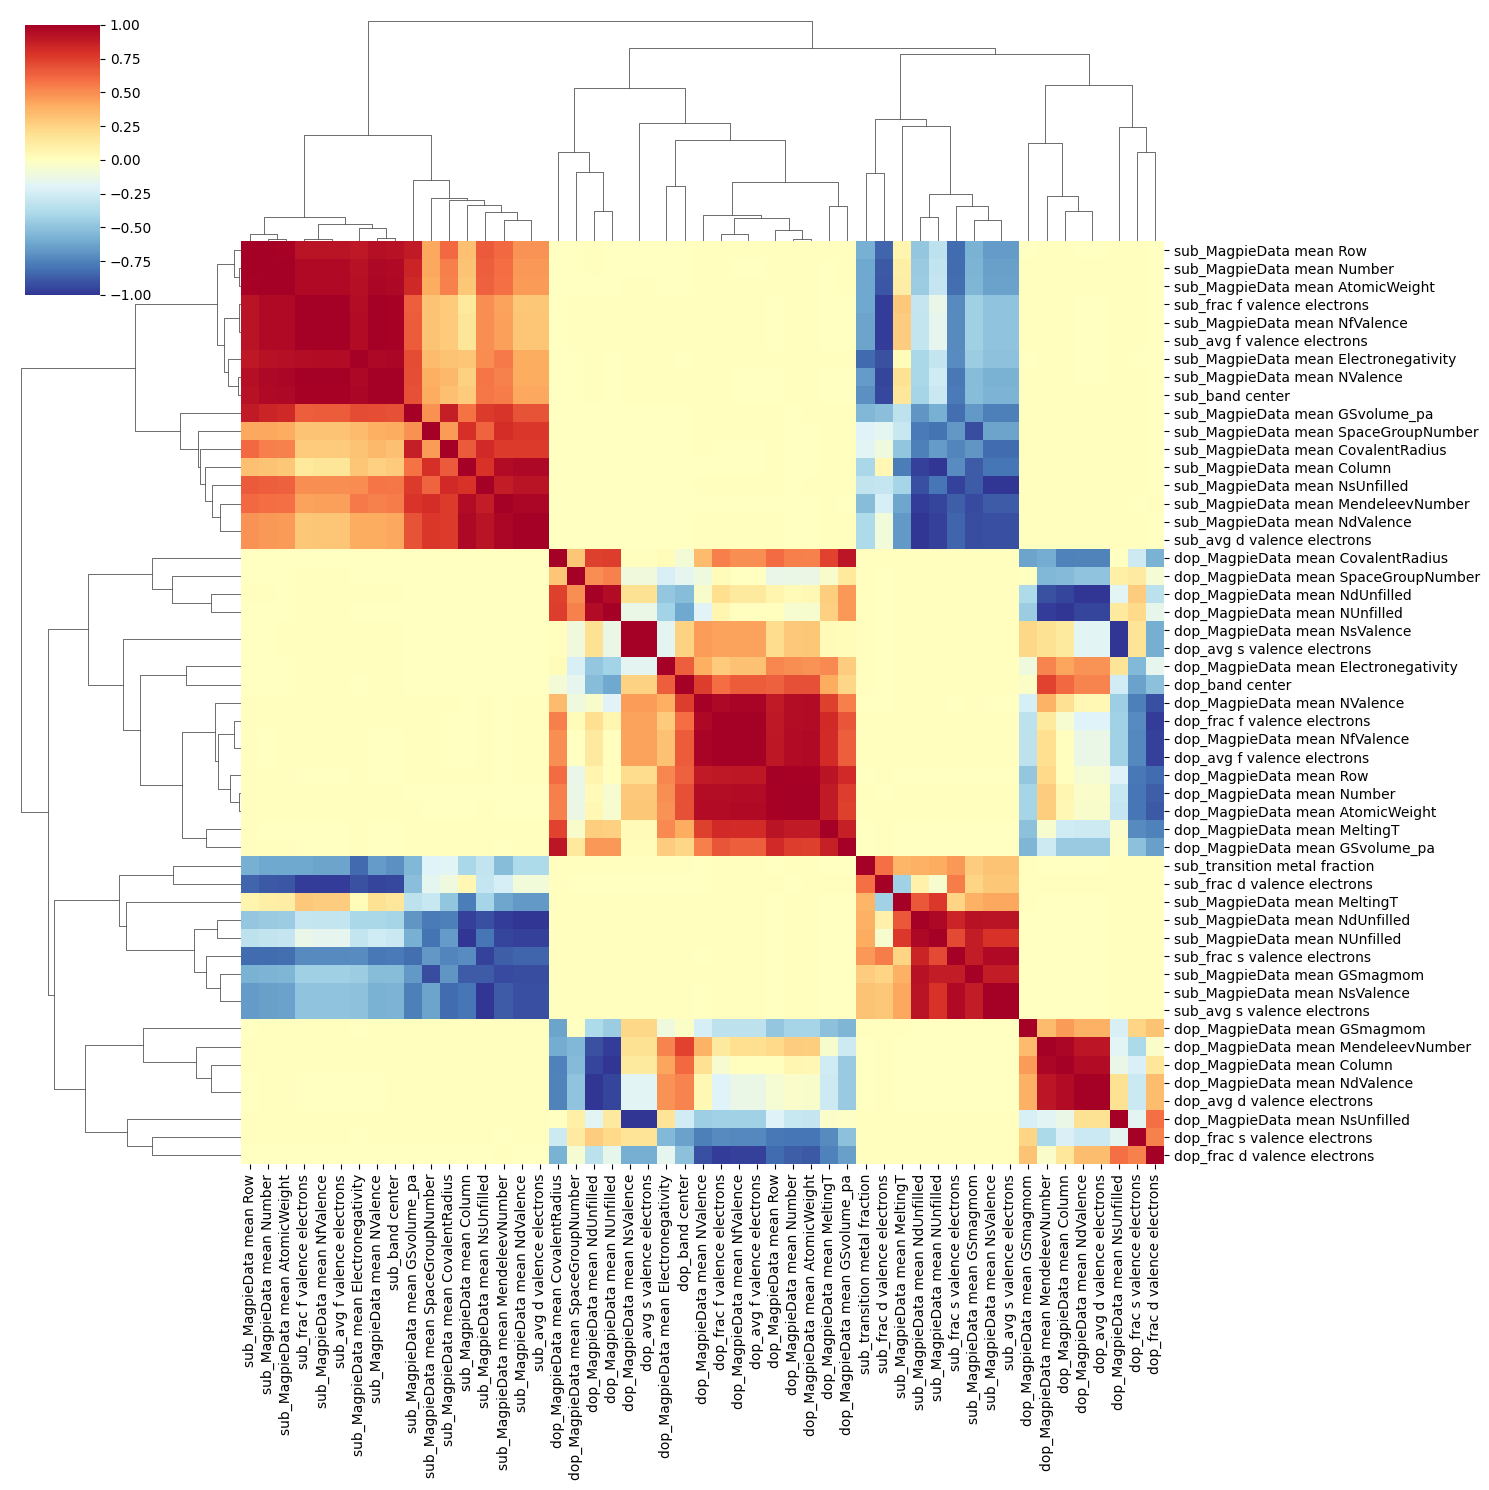

In [211]:
import seaborn as sns
sns.clustermap(X.corr(),
               annot = False,      # 실제 값 화면에 나타내기
               cmap = 'RdYlBu_r',  # Red, Yellow, Blue 색상으로 표시
               vmin = -1, vmax = 1, #컬러차트 -1 ~ 1 범위로 표시
               figsize=(15,15),
              );

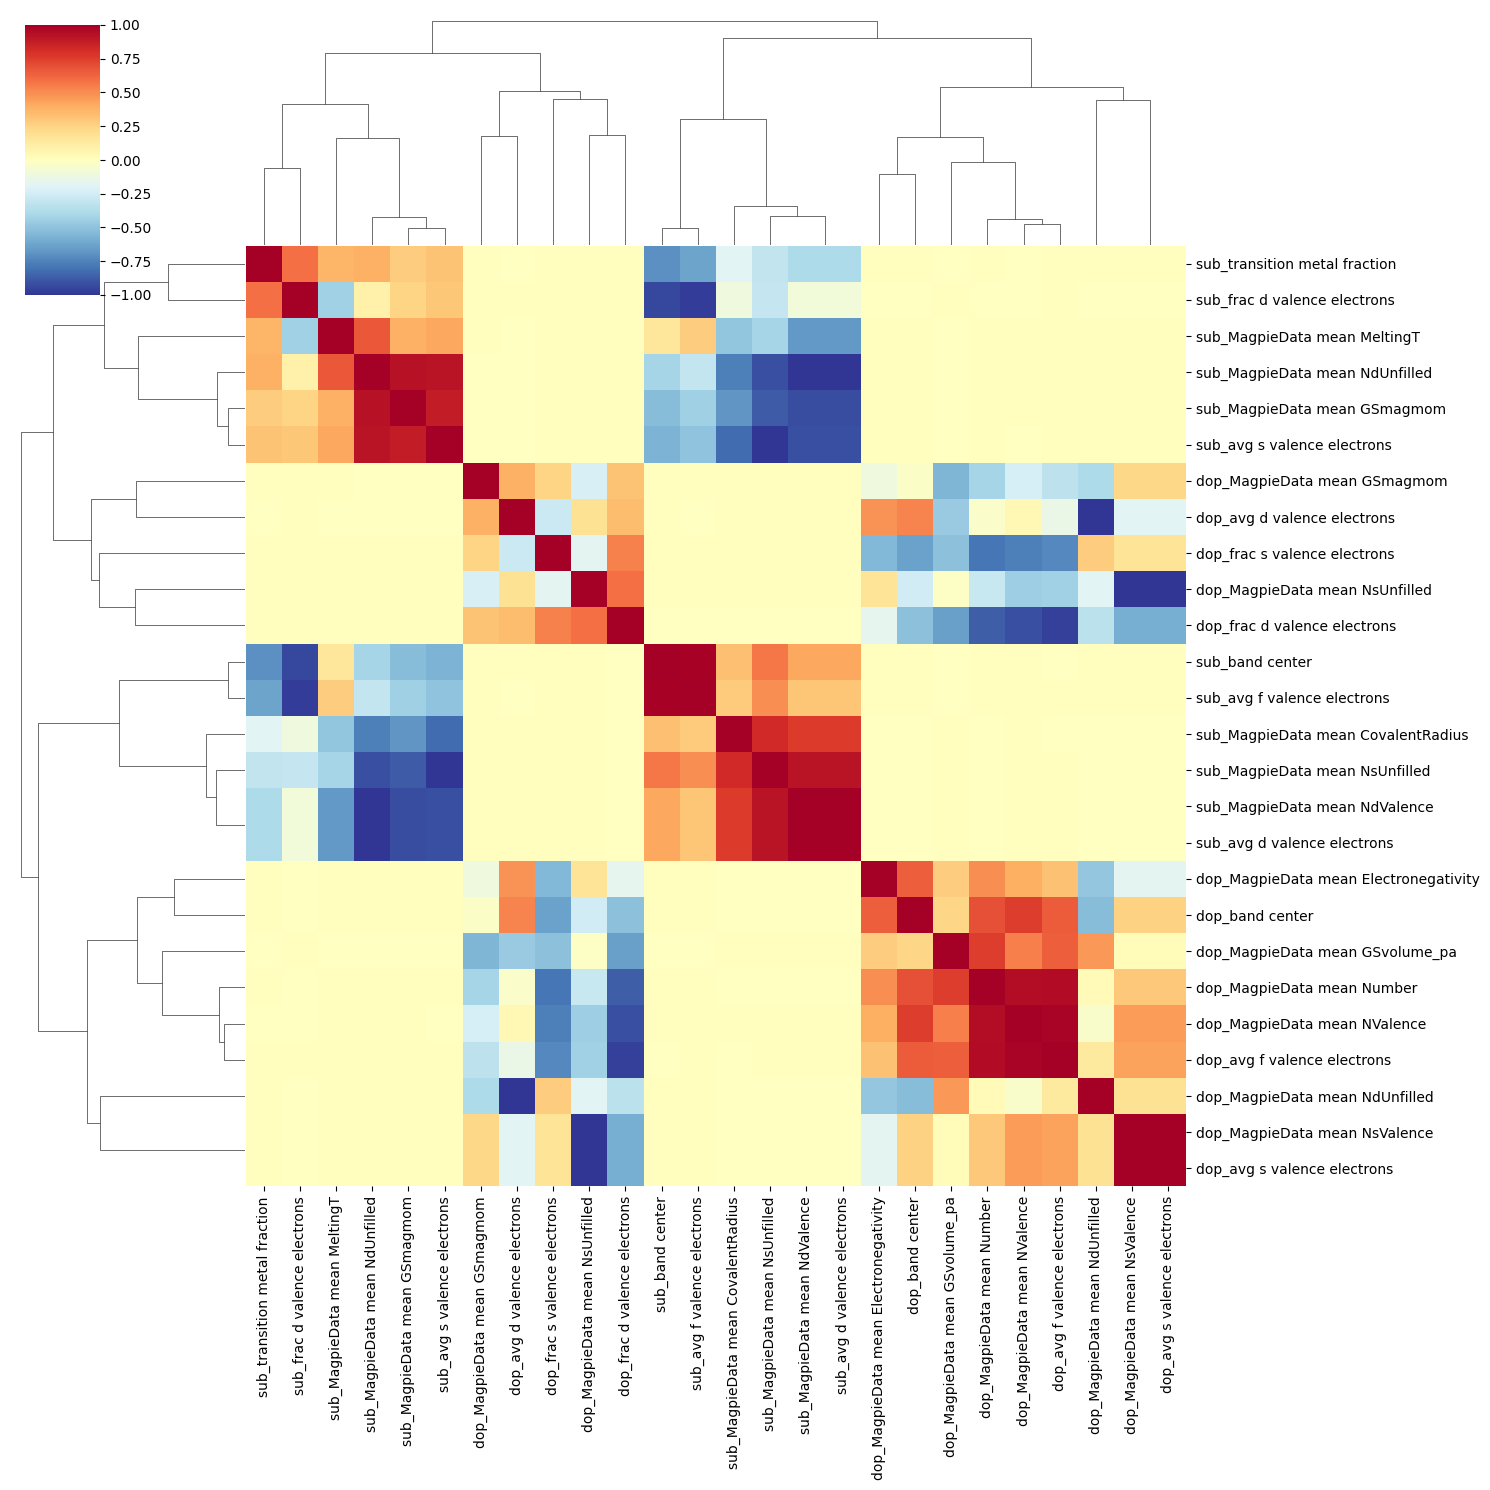

In [217]:
X_reduced = X.drop(['sub_MagpieData mean Column','sub_MagpieData mean Row','dop_MagpieData mean Column','dop_MagpieData mean Row','sub_MagpieData mean SpaceGroupNumber','dop_MagpieData mean SpaceGroupNumber','sub_MagpieData mean AtomicWeight','dop_MagpieData mean AtomicWeight','sub_MagpieData mean MendeleevNumber','dop_MagpieData mean MendeleevNumber', 'sub_MagpieData mean Number','sub_MagpieData mean Number','sub_MagpieData mean GSvolume_pa','dop_MagpieData mean NdValence','sub_MagpieData mean NfValence','dop_MagpieData mean NfValence','sub_MagpieData mean NValence','sub_MagpieData mean NUnfilled','sub_frac f valence electrons','dop_MagpieData mean NUnfilled','dop_frac f valence electrons','sub_MagpieData mean Electronegativity','sub_frac s valence electrons','sub_MagpieData mean NsValence', 'dop_MagpieData mean CovalentRadius','dop_MagpieData mean NdValence','dop_MagpieData mean MeltingT'],axis=1)

sns.clustermap(X_reduced.corr(),
               annot = False,      # 실제 값 화면에 나타내기
               cmap = 'RdYlBu_r',  # Red, Yellow, Blue 색상으로 표시
               vmin = -1, vmax = 1, #컬러차트 -1 ~ 1 범위로 표시
               figsize=(15,15),
              );

In [218]:
def objective(trial):
    n_estimators = trial.suggest_int("n_estimators", 100, 800, step=50) 
    max_depth = trial.suggest_int("max_depth", 1, 10)
    learning_rate = trial.suggest_float("learning_rate", 1e-2, 1e-1, log=True)  
    reg_lambda = trial.suggest_float("reg_lambda", 0.3, 0.6) 
    reg_alpha = trial.suggest_float("reg_alpha", 0.3, 0.6)  

    model = XGBRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        reg_lambda=reg_lambda,
        reg_alpha=reg_alpha,
        early_stopping_rounds=200,
    )
    X_train, X_test, y_train, y_test = train_test_split(X_reduced, target, test_size=1/6, random_state=random_seed)
    model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)

    y_pred = model.predict(X_test)

    accuracy = scorer(y_test,y_pred)
    trial.set_user_attr("accuracy", accuracy)

    return accuracy

In [219]:
stop_search = StopWhenAccuracyOverCrit(0.95)
study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler(seed=3))
study.optimize(objective, callbacks=[stop_search])

[I 2024-06-12 18:15:38,698] A new study created in memory with name: no-name-6387ee33-dc33-4b98-83e2-573d488ac4ac
[I 2024-06-12 18:15:39,585] Trial 0 finished with value: 0.6927411540206441 and parameters: {'n_estimators': 500, 'max_depth': 8, 'learning_rate': 0.019539108247609217, 'reg_lambda': 0.45324828155929886, 'reg_alpha': 0.5678840863042964}. Best is trial 0 with value: 0.6927411540206441.
[I 2024-06-12 18:15:40,035] Trial 1 finished with value: 0.7418540382518202 and parameters: {'n_estimators': 750, 'max_depth': 2, 'learning_rate': 0.01611546636770628, 'reg_lambda': 0.31544016099024896, 'reg_alpha': 0.4322429530951909}. Best is trial 1 with value: 0.7418540382518202.
[I 2024-06-12 18:15:40,192] Trial 2 finished with value: 0.7069502580503482 and parameters: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.0445804089021127, 'reg_lambda': 0.38354618479439256, 'reg_alpha': 0.5028764705940394}. Best is trial 1 with value: 0.7418540382518202.
[I 2024-06-12 18:15:40,401] Tri

KeyboardInterrupt: 

Best parameters: {'n_estimators': 600, 'max_depth': 2, 'learning_rate': 0.09921009072158107, 'reg_lambda': 0.5250547188846084, 'reg_alpha': 0.3387785774536139}
[0]	validation_0-rmse:0.99369
[1]	validation_0-rmse:0.94102
[2]	validation_0-rmse:0.88771
[3]	validation_0-rmse:0.84056
[4]	validation_0-rmse:0.79229
[5]	validation_0-rmse:0.74964
[6]	validation_0-rmse:0.71293
[7]	validation_0-rmse:0.67781
[8]	validation_0-rmse:0.65113
[9]	validation_0-rmse:0.62585
[10]	validation_0-rmse:0.60081
[11]	validation_0-rmse:0.58137
[12]	validation_0-rmse:0.56166
[13]	validation_0-rmse:0.53953
[14]	validation_0-rmse:0.52878
[15]	validation_0-rmse:0.51912
[16]	validation_0-rmse:0.51189
[17]	validation_0-rmse:0.50564
[18]	validation_0-rmse:0.49071
[19]	validation_0-rmse:0.48616
[20]	validation_0-rmse:0.47451
[21]	validation_0-rmse:0.46726
[22]	validation_0-rmse:0.46444
[23]	validation_0-rmse:0.45734
[24]	validation_0-rmse:0.45024
[25]	validation_0-rmse:0.44744
[26]	validation_0-rmse:0.44459
[27]	validati

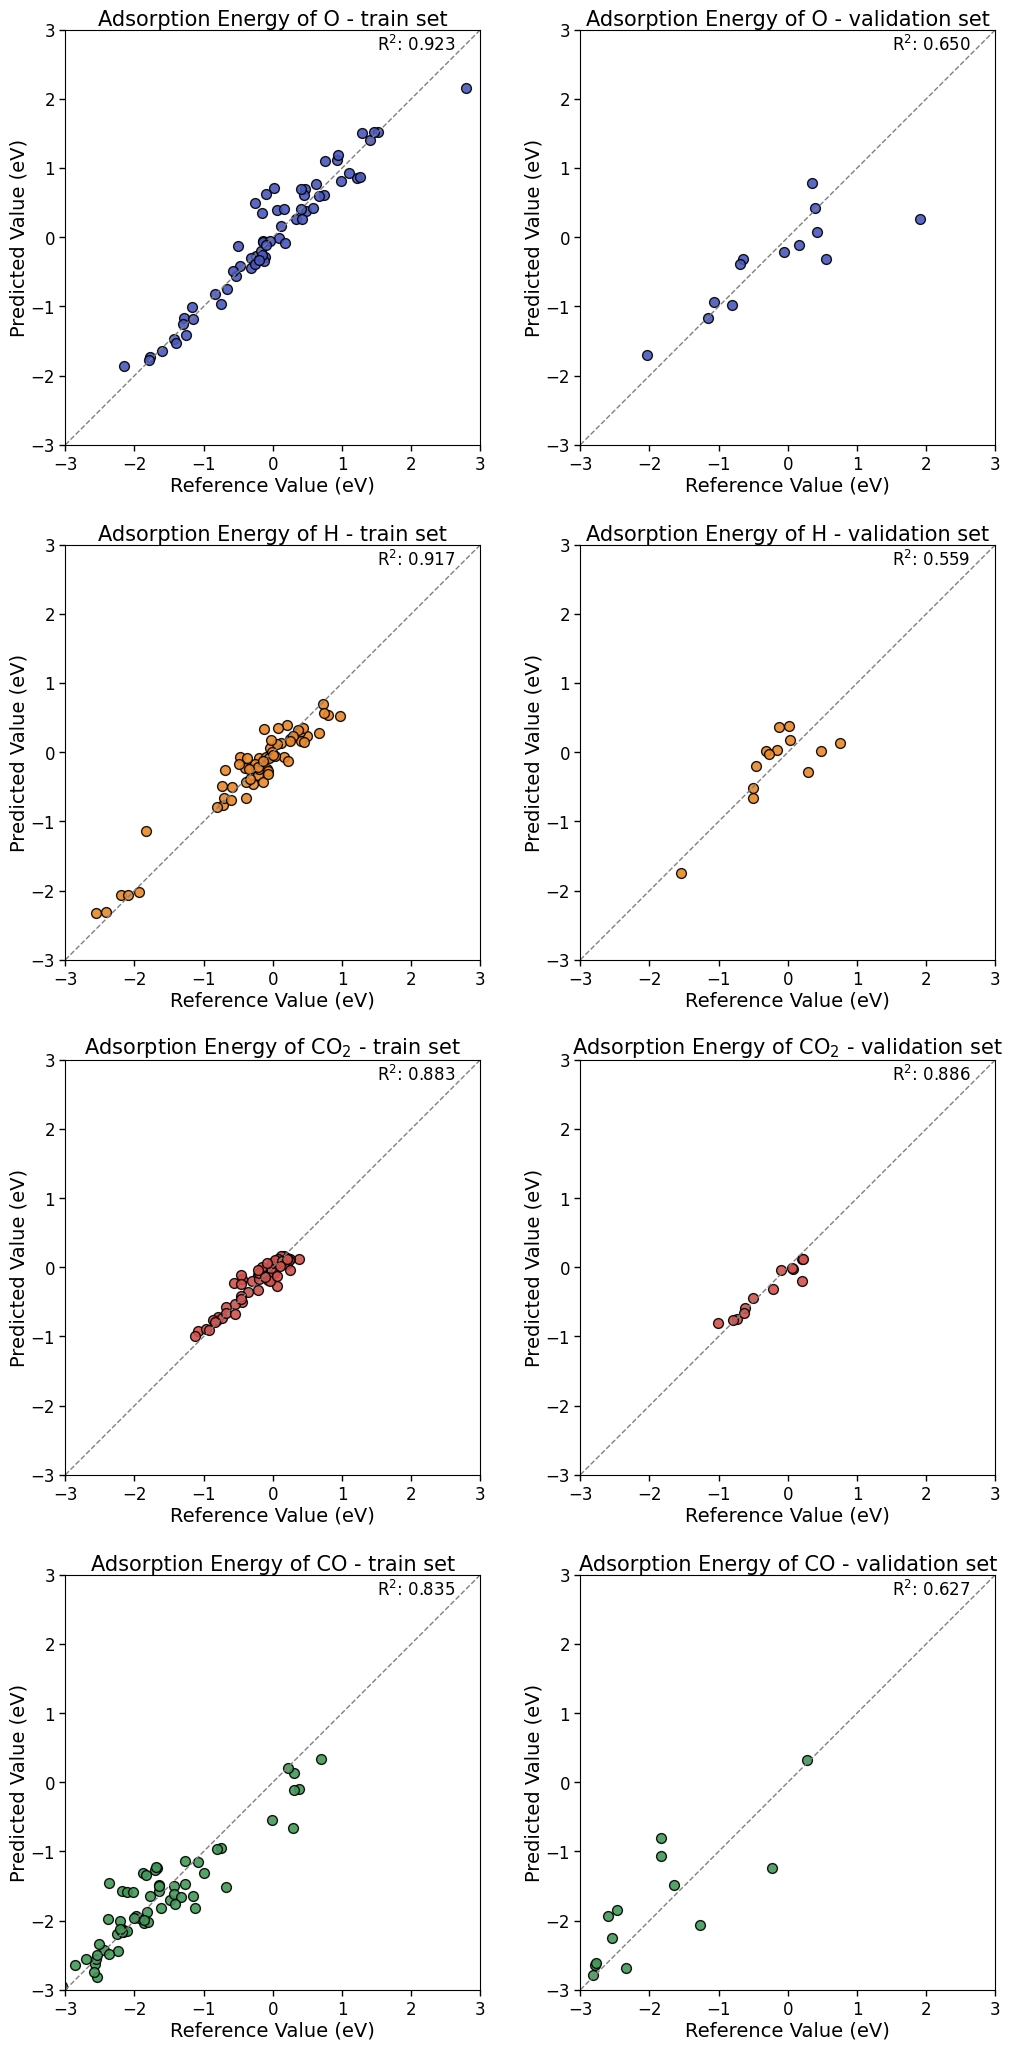

In [220]:
study.best_params
print("Best parameters:", study.best_params)

xgbr_trainer(study=study, model_name='xgbr_reduced')


## XGBRegressor - feature reduction + weight on CO (5)

In [221]:
from xgboost import XGBRegressor
# try XGBRegressor

def scorer(y_test, y_pred):
    r2_O = r2_score(y_test['E_O'], y_pred.T[0])
    r2_H = r2_score(y_test['E_H'], y_pred.T[1])
    r2_CO2 = r2_score(y_test['E_CO2'], y_pred.T[2])
    r2_CO = r2_score(y_test['E_CO'], y_pred.T[3])
    
    r2 =  (r2_O  +  r2_H + r2_CO2 + 5*r2_CO)
    return r2/8


def objective(trial):
    n_estimators = trial.suggest_int("n_estimators", 100, 800, step=50) 
    max_depth = trial.suggest_int("max_depth", 1, 10)
    learning_rate = trial.suggest_float("learning_rate", 1e-2, 1e-1, log=True)  
    reg_lambda = trial.suggest_float("reg_lambda", 0.3, 0.6) 
    reg_alpha = trial.suggest_float("reg_alpha", 0.3, 0.6)  

    model = XGBRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        reg_lambda=reg_lambda,
        reg_alpha=reg_alpha,
        early_stopping_rounds=200,
    )
    X_train, X_test, y_train, y_test = train_test_split(X_reduced, target, test_size=1/6, random_state=random_seed)
    model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)

    y_pred = model.predict(X_test)

    accuracy = scorer(y_test,y_pred)
    trial.set_user_attr("accuracy", accuracy)

    return accuracy

class StopWhenAccuracyOverCrit:  
    def __init__(self, crit): 
        self.crit = crit 

    def __call__(self, study, trial) -> None:        
        if trial.user_attrs["accuracy"] > self.crit:  
            study.stop() 
            

def xgbr_trainer(study, model_name, X = None, return_model = False):
    if X is None:
        X = X
    X_train, X_test, y_train, y_test = train_test_split(X_reduced, target, test_size=1/6, random_state=random_seed)
    model = XGBRegressor(**study.best_params)
    model.fit(X_train, y_train, eval_set=[(X_test, y_test)])
    y_pred_train = model.predict(X_train) 
    y_pred_test = model.predict(X_test) 
    Y = [[y_train, y_pred_train], [y_test,y_pred_test]]
    
    r2_O = r2_score(y_test['E_O'], y_pred_test.T[0])
    r2_H = r2_score(y_test['E_H'], y_pred_test.T[1])
    r2_CO2 = r2_score(y_test['E_CO2'], y_pred_test.T[2])
    r2_CO = r2_score(y_test['E_CO'], y_pred_test.T[3])

    print(f"r2_score of E_O at test set: {round(r2_O, 3)}")
    print(f"r2_score of E_H at test set: {round(r2_H, 3)}")
    print(f"r2_score of E_CO2 at test set: {round(r2_CO2, 3)}")
    print(f"r2_score of E_CO at test set: {round(r2_CO, 3)}")

    data = {'X': X, 'Y':Y,'params':model.get_params(),'study':study, 'study_best_params':study.best_params}
    
    path = f'./models/{model_name}'
    if not os.path.exists(path):
        os.makedirs(path)
    
    with open(os.path.join(path, f'{model_name}_pickle.pkl'), 'wb') as file:
        pickle.dump(model, file)
    
    joblib.dump(model, os.path.join(path,f'{model_name}_joblib.pkl'))
    
    with open(os.path.join(path,'data.pkl'),'wb') as file:
        pickle.dump(data, file)
        
    plotparities(Y)
    
    if return_model:
        return model
    else:
        return

In [222]:
stop_search = StopWhenAccuracyOverCrit(0.95)
study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler(seed=3))
study.optimize(objective, callbacks=[stop_search])

[I 2024-06-12 18:31:07,762] A new study created in memory with name: no-name-f02dcac3-e114-4dbb-b8b0-da73e5a0a414
[I 2024-06-12 18:31:08,475] Trial 0 finished with value: 0.6567169461464917 and parameters: {'n_estimators': 500, 'max_depth': 8, 'learning_rate': 0.019539108247609217, 'reg_lambda': 0.45324828155929886, 'reg_alpha': 0.5678840863042964}. Best is trial 0 with value: 0.6567169461464917.
[I 2024-06-12 18:31:08,778] Trial 1 finished with value: 0.7065964138607739 and parameters: {'n_estimators': 750, 'max_depth': 2, 'learning_rate': 0.01611546636770628, 'reg_lambda': 0.31544016099024896, 'reg_alpha': 0.4322429530951909}. Best is trial 1 with value: 0.7065964138607739.
[I 2024-06-12 18:31:08,927] Trial 2 finished with value: 0.6752940314347584 and parameters: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.0445804089021127, 'reg_lambda': 0.38354618479439256, 'reg_alpha': 0.5028764705940394}. Best is trial 1 with value: 0.7065964138607739.
[I 2024-06-12 18:31:09,120] Tri

KeyboardInterrupt: 

Best parameters: {'n_estimators': 500, 'max_depth': 2, 'learning_rate': 0.07955566757813362, 'reg_lambda': 0.47976463984824275, 'reg_alpha': 0.36395177396580913}
[0]	validation_0-rmse:1.00608
[1]	validation_0-rmse:0.95481
[2]	validation_0-rmse:0.90875
[3]	validation_0-rmse:0.86592
[4]	validation_0-rmse:0.82498
[5]	validation_0-rmse:0.78760
[6]	validation_0-rmse:0.76052
[7]	validation_0-rmse:0.72898
[8]	validation_0-rmse:0.69566
[9]	validation_0-rmse:0.67621
[10]	validation_0-rmse:0.65478
[11]	validation_0-rmse:0.63400
[12]	validation_0-rmse:0.60977
[13]	validation_0-rmse:0.58940
[14]	validation_0-rmse:0.56937
[15]	validation_0-rmse:0.55725
[16]	validation_0-rmse:0.53841
[17]	validation_0-rmse:0.52904
[18]	validation_0-rmse:0.51600
[19]	validation_0-rmse:0.50774
[20]	validation_0-rmse:0.49381
[21]	validation_0-rmse:0.48711
[22]	validation_0-rmse:0.48058
[23]	validation_0-rmse:0.47215
[24]	validation_0-rmse:0.46587
[25]	validation_0-rmse:0.45571
[26]	validation_0-rmse:0.44668
[27]	valida

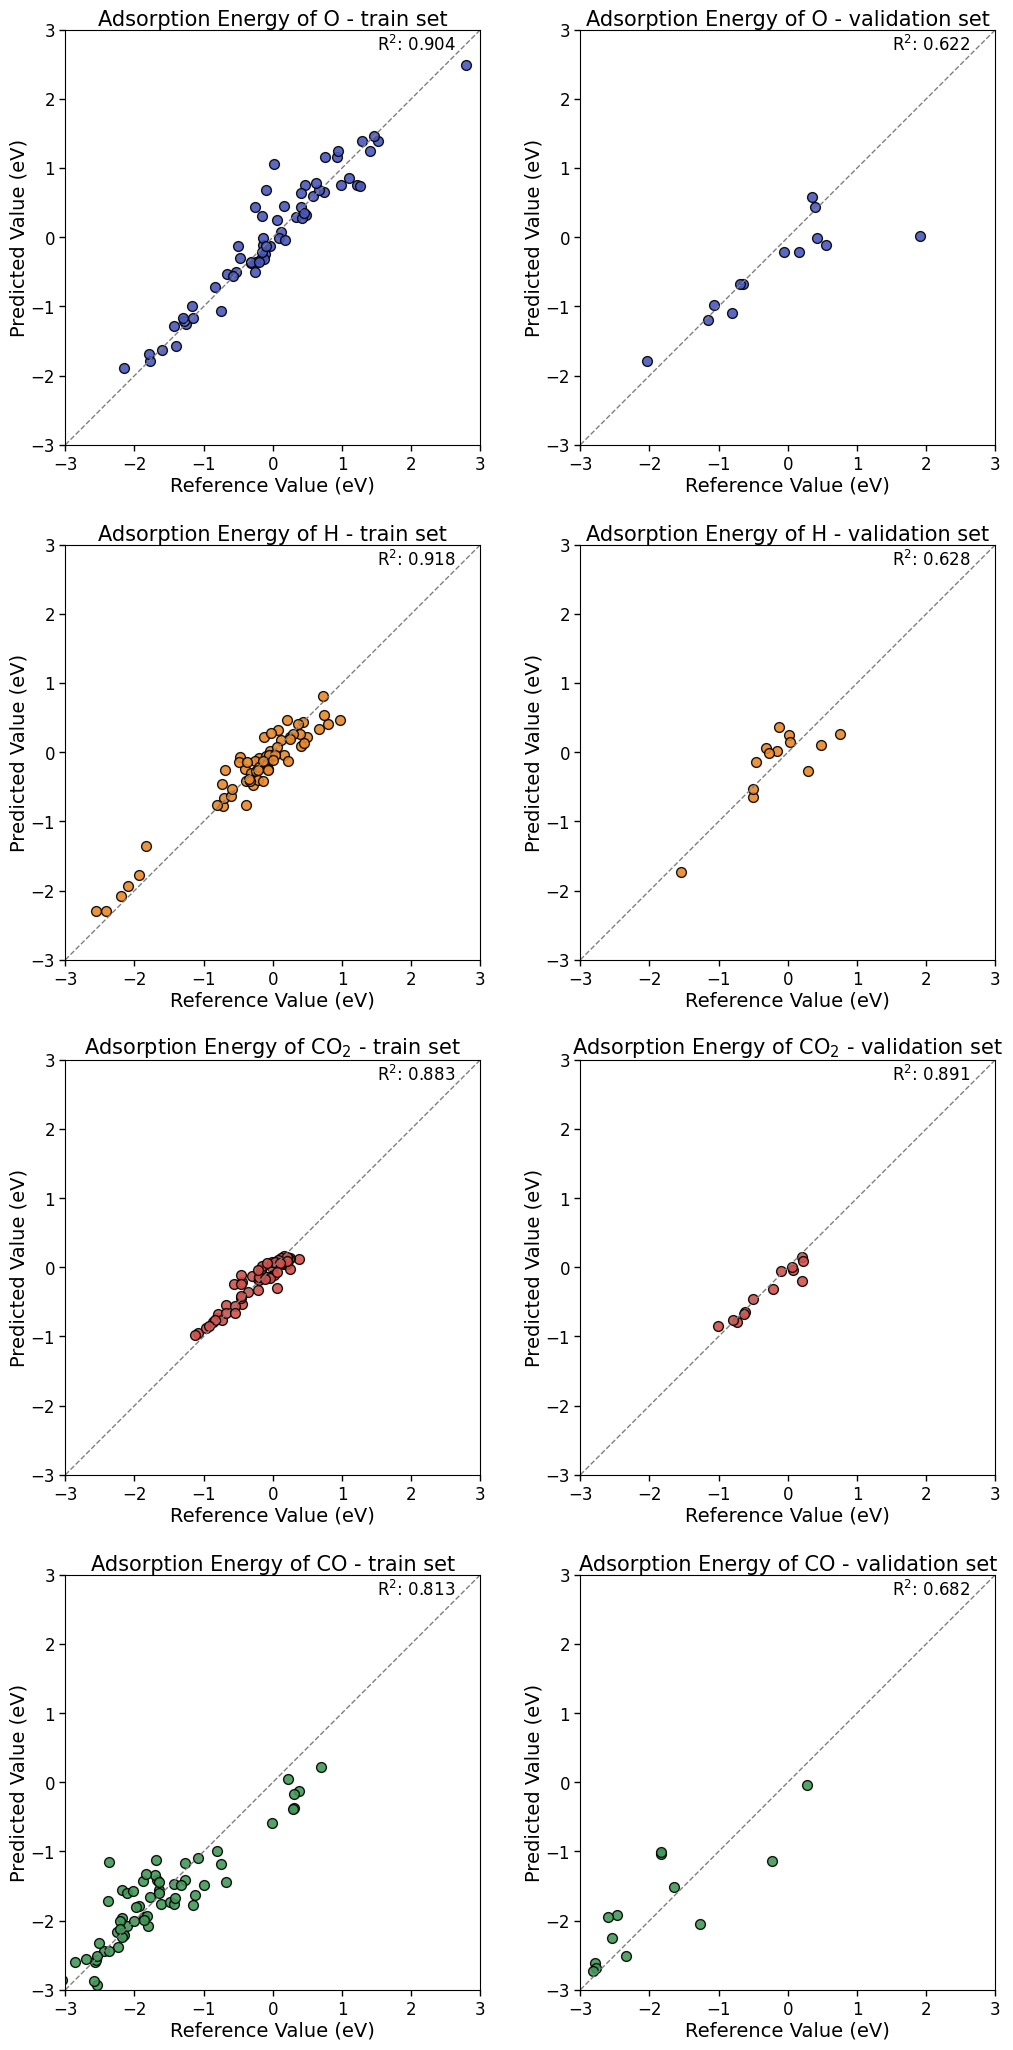

In [223]:
study.best_params
print("Best parameters:", study.best_params)

xgbr_trainer(study=study, model_name='xgbr_weight5')


## XGBRegressor - feature reduction + weight on CO (10)

In [224]:
from xgboost import XGBRegressor
# try XGBRegressor

def scorer(y_test, y_pred):
    r2_O = r2_score(y_test['E_O'], y_pred.T[0])
    r2_H = r2_score(y_test['E_H'], y_pred.T[1])
    r2_CO2 = r2_score(y_test['E_CO2'], y_pred.T[2])
    r2_CO = r2_score(y_test['E_CO'], y_pred.T[3])
    
    r2 =  (r2_O  +  r2_H + r2_CO2 + 10*r2_CO)
    return r2/13


def objective(trial):
    n_estimators = trial.suggest_int("n_estimators", 100, 800, step=50) 
    max_depth = trial.suggest_int("max_depth", 1, 10)
    learning_rate = trial.suggest_float("learning_rate", 1e-2, 1e-1, log=True)  
    reg_lambda = trial.suggest_float("reg_lambda", 0.3, 0.6) 
    reg_alpha = trial.suggest_float("reg_alpha", 0.3, 0.6)  

    model = XGBRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        reg_lambda=reg_lambda,
        reg_alpha=reg_alpha,
        early_stopping_rounds=200,
    )
    X_train, X_test, y_train, y_test = train_test_split(X_reduced, target, test_size=1/6, random_state=random_seed)
    model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)

    y_pred = model.predict(X_test)

    accuracy = scorer(y_test,y_pred)
    trial.set_user_attr("accuracy", accuracy)

    return accuracy

class StopWhenAccuracyOverCrit:  
    def __init__(self, crit): 
        self.crit = crit 

    def __call__(self, study, trial) -> None:        
        if trial.user_attrs["accuracy"] > self.crit:  
            study.stop() 
            
# Define function for model selection 

def xgbr_trainer(study, model_name, X = None, return_model = False):
    if X is None:
        X = X
    X_train, X_test, y_train, y_test = train_test_split(X_reduced, target, test_size=1/6, random_state=random_seed)
    model = XGBRegressor(**study.best_params)
    model.fit(X_train, y_train, eval_set=[(X_test, y_test)])
    y_pred_train = model.predict(X_train) 
    y_pred_test = model.predict(X_test) 
    Y = [[y_train, y_pred_train], [y_test,y_pred_test]]
    
    r2_O = r2_score(y_test['E_O'], y_pred_test.T[0])
    r2_H = r2_score(y_test['E_H'], y_pred_test.T[1])
    r2_CO2 = r2_score(y_test['E_CO2'], y_pred_test.T[2])
    r2_CO = r2_score(y_test['E_CO'], y_pred_test.T[3])

    print(f"r2_score of E_O at test set: {round(r2_O, 3)}")
    print(f"r2_score of E_H at test set: {round(r2_H, 3)}")
    print(f"r2_score of E_CO2 at test set: {round(r2_CO2, 3)}")
    print(f"r2_score of E_CO at test set: {round(r2_CO, 3)}")

    
    data = {'X': X, 'Y':Y,'params':model.get_params(),'study':study, 'study_best_params':study.best_params}
    
    path = f'./models/{model_name}'
    if not os.path.exists(path):
        os.makedirs(path)
    
    with open(os.path.join(path, f'{model_name}_pickle.pkl'), 'wb') as file:
        pickle.dump(model, file)
    
    joblib.dump(model, os.path.join(path,f'{model_name}_joblib.pkl'))
    
    with open(os.path.join(path,'data.pkl'),'wb') as file:
        pickle.dump(data, file)
        
    plotparities(Y)
    
    if return_model:
        return model
    else:
        return

In [225]:
stop_search = StopWhenAccuracyOverCrit(0.95)
study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler(seed=3))
study.optimize(objective, callbacks=[stop_search])

[I 2024-06-12 18:35:23,430] A new study created in memory with name: no-name-7867ee3b-24a1-4e13-b1ca-ef161102708b
[I 2024-06-12 18:35:29,224] Trial 0 finished with value: 0.6428614815795102 and parameters: {'n_estimators': 500, 'max_depth': 8, 'learning_rate': 0.019539108247609217, 'reg_lambda': 0.45324828155929886, 'reg_alpha': 0.5678840863042964}. Best is trial 0 with value: 0.6428614815795102.
[I 2024-06-12 18:35:30,036] Trial 1 finished with value: 0.6930357890949868 and parameters: {'n_estimators': 750, 'max_depth': 2, 'learning_rate': 0.01611546636770628, 'reg_lambda': 0.31544016099024896, 'reg_alpha': 0.4322429530951909}. Best is trial 1 with value: 0.6930357890949868.
[I 2024-06-12 18:35:30,396] Trial 2 finished with value: 0.6631185596595317 and parameters: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.0445804089021127, 'reg_lambda': 0.38354618479439256, 'reg_alpha': 0.5028764705940394}. Best is trial 1 with value: 0.6930357890949868.
[I 2024-06-12 18:35:30,921] Tri

KeyboardInterrupt: 

Best parameters: {'n_estimators': 800, 'max_depth': 7, 'learning_rate': 0.0799528793296663, 'reg_lambda': 0.5537252613879537, 'reg_alpha': 0.4133982123986667}
[0]	validation_0-rmse:1.00128
[1]	validation_0-rmse:0.94651
[2]	validation_0-rmse:0.89661
[3]	validation_0-rmse:0.85287
[4]	validation_0-rmse:0.81111
[5]	validation_0-rmse:0.77462
[6]	validation_0-rmse:0.74089
[7]	validation_0-rmse:0.71737
[8]	validation_0-rmse:0.69095
[9]	validation_0-rmse:0.66742
[10]	validation_0-rmse:0.64316
[11]	validation_0-rmse:0.62189
[12]	validation_0-rmse:0.60450
[13]	validation_0-rmse:0.58535
[14]	validation_0-rmse:0.56899
[15]	validation_0-rmse:0.55942
[16]	validation_0-rmse:0.54611
[17]	validation_0-rmse:0.53376
[18]	validation_0-rmse:0.52719
[19]	validation_0-rmse:0.51796
[20]	validation_0-rmse:0.51181
[21]	validation_0-rmse:0.50582
[22]	validation_0-rmse:0.50007
[23]	validation_0-rmse:0.49430
[24]	validation_0-rmse:0.48950
[25]	validation_0-rmse:0.48576
[26]	validation_0-rmse:0.48222
[27]	validatio

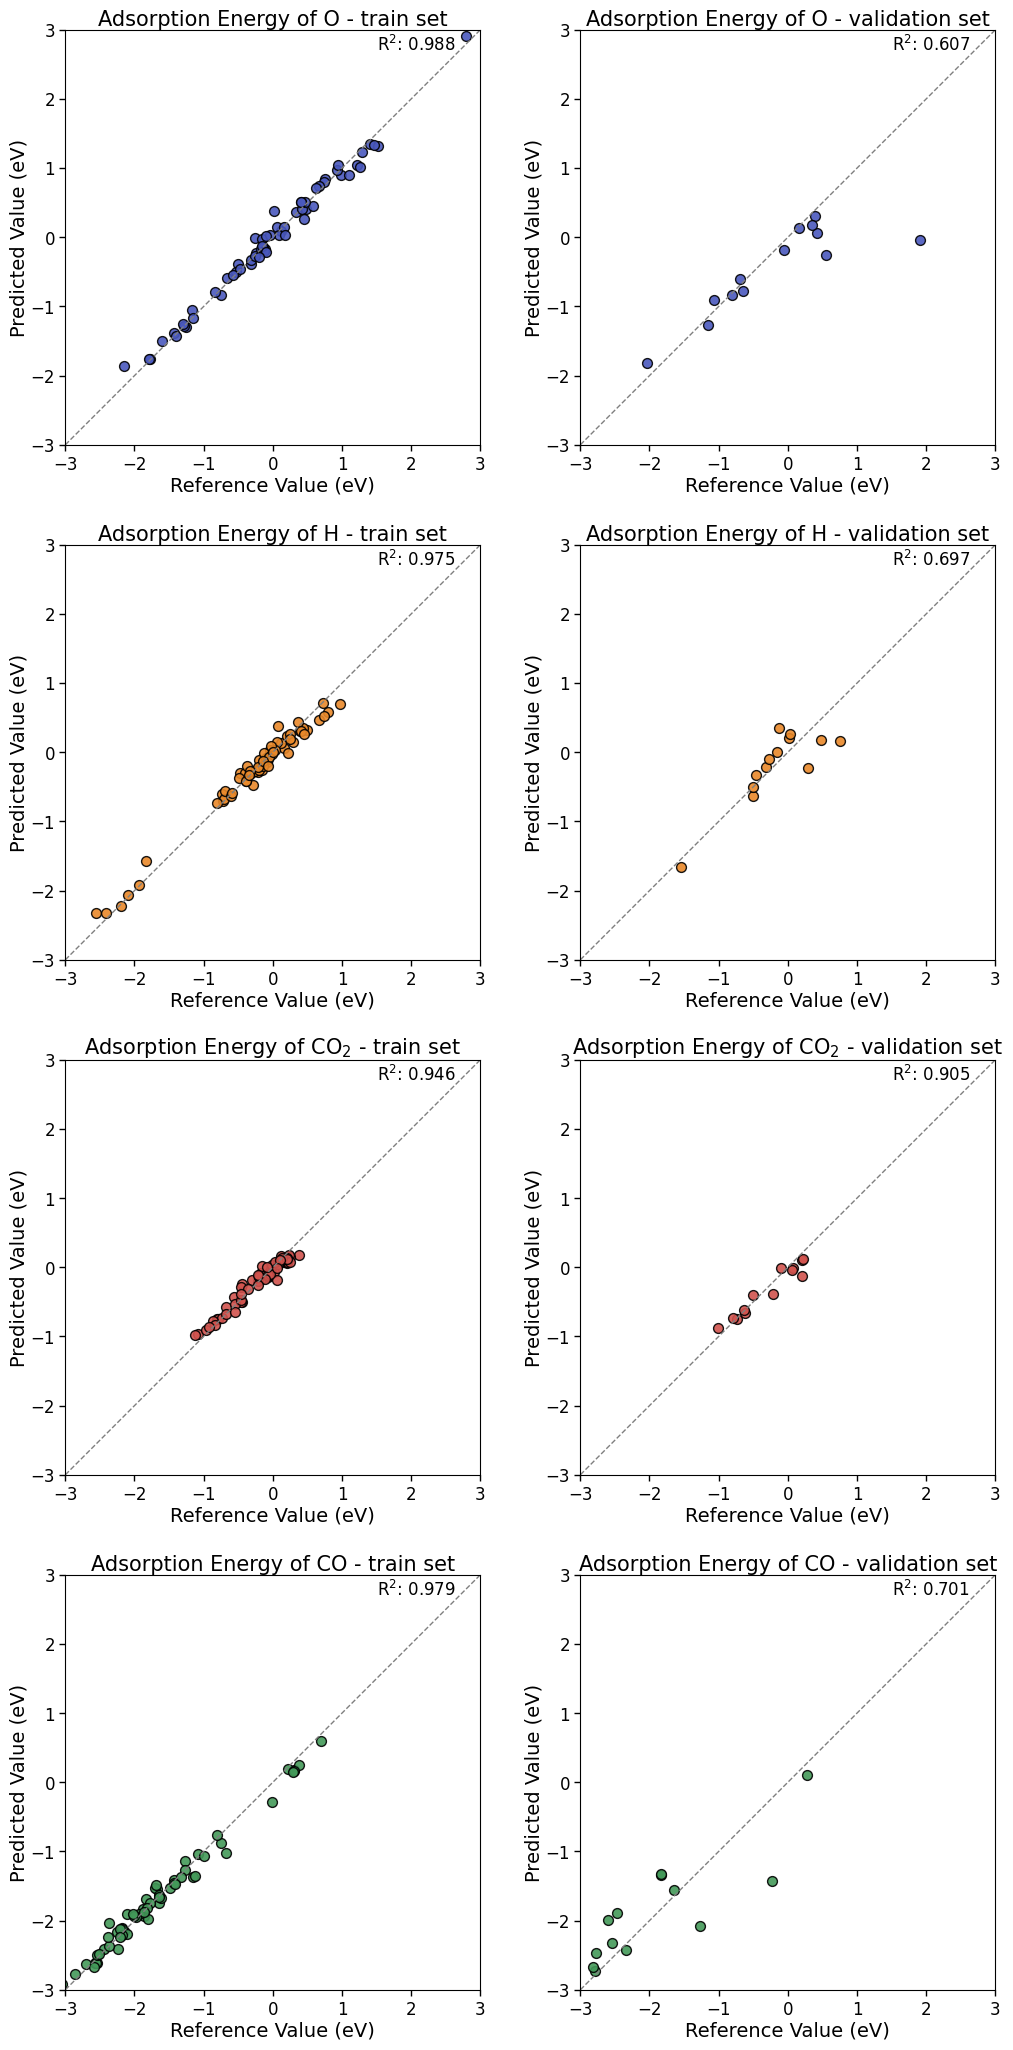

In [226]:
study.best_params
print("Best parameters:", study.best_params)

xgbr_trainer(study=study, model_name='xgbr_weight10')
